**"I / we certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I/we did not receive any external help, coaching, or contributions
during the production of this work."**

In [31]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage)
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**PART 1**

# Cart-Pole Example

In [32]:
# Creating the Gym Environment for the Cart Pole example
env = gym.make("CartPole-v1")
observations = env.reset()
print(observations)

[-0.01668064  0.03650586  0.0228334   0.02650987]


### Observation Vector of the Cart-Pole Example contains
- Cart Position in x direction
- Cart Velocity 
- Pole Angle - Radians
- Pole Angular Velocity

#### Printing out the Member Variables of the Observation Space class (Box)

In [33]:
print(env.observation_space.__dict__)

{'dtype': dtype('float32'), 'shape': (4,), 'low': array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), 'high': array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32), 'bounded_below': array([ True,  True,  True,  True]), 'bounded_above': array([ True,  True,  True,  True]), '_np_random': None}


#### Printing out the Minimum values of the Observation Space in order of
- Cart Position in x direction
- Cart Velocity 
- Pole Angle 
- Pole Angular Velocity

In [34]:
print(env.observation_space.low)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


#### Printing out the Maximum values of the Observation Space in order of
- Cart Position in x direction
- Cart Velocity 
- Pole Angle
- Pole Angular Velocity

In [35]:
print(env.observation_space.high)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


### Action space is a object of discrete class, printing out the member variables

In [36]:
print(env.action_space.__dict__)

{'n': 2, 'shape': (), 'dtype': dtype('int64'), '_np_random': None}


#### Since only the n member variable is set and not the start it will create a list/set of n-1 numbers, indicating the available actions
* Available Actions
    * 0 - Go Left
    * 1 - Go Right

In [37]:
print(env.action_space.n)

2


### Goal
* Goal of this environment is to balance the pole for as long as possible

### Rewards
* Agent receives a reward of +1 each timestep if the certain conditions are met, these are the following conditions
    * The threshed for x_direction is in range of (-2.4, 2.4)
    * The angle of the the pole is in threshold of (-0.20,0.209)
* Else the agent receives the reward of 0 and the state is terminated if the conditions are not met

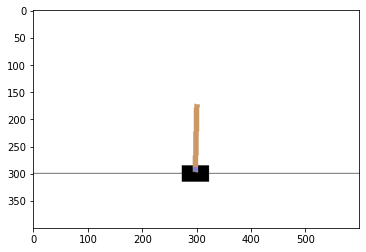

In [38]:
plt.imshow(env.render('rgb_array'))
env.close()
    

# Mountain Car Example

In [39]:
# Creating the Gym Environment for the Cart Pole example
env = gym.make("MountainCar-v0")
observations = env.reset()

### Observation Vector of the Mountain Car Example contains
- Position of the car along x axis
- Velocity of the car

In [40]:
# Member variables of the observation space (Box Class)
print(env.observation_space.__dict__)

{'dtype': dtype('float32'), 'shape': (2,), 'low': array([-1.2 , -0.07], dtype=float32), 'high': array([0.6 , 0.07], dtype=float32), 'bounded_below': array([ True,  True]), 'bounded_above': array([ True,  True]), '_np_random': None}


#### Printing out the Minimum values of the Observation Space in order of
- Position of the car along x axis
- Velocity of the car

In [41]:
print(env.observation_space.low)

[-1.2  -0.07]


#### Printing out the Maximum values of the Observation Space in order of
- Position of the car along x axis
- Velocity of the car

In [42]:
print(env.observation_space.high)

[0.6  0.07]


### Action space is a object of discrete class, printing out the member variables


In [43]:
print(env.action_space.__dict__)

{'n': 3, 'shape': (), 'dtype': dtype('int64'), '_np_random': None}


#### Since only the n member variable is set and not the start it will create a list/set of n-1 numbers, indicating the available actions
* Available Actions 
    * 0 - Accelerate to the left
    * 1 - Don't accelerate
    * 2 - Accelerate to the right

In [44]:
print(env.action_space.n)

3


### Goal
- Here the agent has to reach the flag placed on the top of the mountain as quickly as possible.

### Reward
* Here the agent is penalized by the reward of -1 if the agent isn't at goal position, and is not penalized when is at goal position. (reward = 0)
* Termination Criteria are,
    * If the car reaches the goal position (i.e. value of x axis would be equal to 0.5)
    * The length of the episode is 200

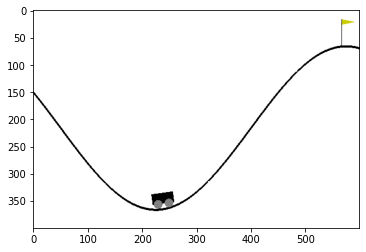

In [45]:
plt.imshow(env.render('rgb_array'))
env.close()

**PART 2**

In [46]:
class DQNmodel(nn.Module):
    
    def __init__(self, n_inputs, n_actions, lr,hiddennodes):
        super().__init__()
        self.hNodes = hiddennodes
        self.fc1 = nn.Linear(n_inputs, self.hNodes)
        self.fc2 = nn.Linear(self.hNodes,self.hNodes)
        # self.fc3 = nn.Linear(self.hNodes,self.hNodes)
        self.fc3 = nn.Linear(self.hNodes, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        # x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return x



In [47]:
class experience:

    def __init__(self):
        self.exp_buffer = []


    def empty_buffer(self):

        self.exp_buffer = []

    def __len__(self):
        return len(self.exp_buffer)


    def log_exp(self, input_vector_s1, action_current, reward,input_vector_s2):
        input_vector_s1 = input_vector_s1.type(torch.float)
        input_vector_s2 = input_vector_s2.type(torch.float)
        action_current = torch.tensor(action_current).type(torch.float)
        reward = torch.tensor(reward).type(torch.float)

        exp_vector = [input_vector_s1, action_current,reward, input_vector_s2]

        self.exp_buffer.append(exp_vector)

    

    def get_exp(self):

        return self.exp_buffer

In [48]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['stochastic','deterministic'] }
    """
      Observation vector values meaning
      1 -> Agent
      2 -> Skeleton 1
      2 -> Skeleton 2
      3 -> Bird
      3 -> Fire
      4 -> Princess


    """
    # Different Environment Characters and rewards position
    monster = [[3,0], [1,1]]
    bird = [0,3]
    fire = [2,3]
    bird_quantity = 1
    fire_quantity = 1
    state = np.zeros((4,4))
    environment_height = 4
    environment_width = 4
    goal_flag = False
    
    # reward = 0


    def __init__(self, max_timestep):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        # self.max_timesteps = 100
        self.max_timesteps= max_timestep
    def reset(self):

        # Timesteps
        self.timestep = 0
        self.agent_pos = [0, 0] # Starting position to the 
        self.agent_pos_prev = [0, 3] # Starting position to the
        self.princess = [3,3] # Setting the goal positiion to the corner of the env
        self.state = np.zeros((4,4))
        self.bird_quantity = 1
        self.fire_quantity = 1
        
        # Agent Position
        self.state[tuple(self.agent_pos)] = 1
        
        # Skeleton 1 Position
        self.state[tuple(self.monster[0])] = 2

        # Skeleton 2 Position
        self.state[tuple(self.monster[1])] = 2

        # Bird Position
        self.state[tuple(self.bird)] = 3

        # Fire Position 
        self.state[tuple(self.fire)] = 3

        # Princess Position
        self.state[tuple(self.princess)] = 4
          
          

        observation = self.state.flatten() # Environment states -> Observations
        return observation
    
    def step(self, action):
        done = False
        reward = 0

        state_flag = True

        self.state = np.zeros((4,4))      
        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
           self.agent_pos[0] -= 1
        if action == 2:
           self.agent_pos[1] += 1
        if action == 3:
           self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 3)


        # Updating the values of the characters in the observation vector

        # Agent Position
        self.state[tuple(self.agent_pos)] = 1


       

        # Flattening out the observation vector
        observation = self.state.flatten()


        # Adding different rewards
        # reward = 0
        if (self.agent_pos == self.princess).all():
          reward = 4
          self.goal_flag = True
          done = True
          
        elif (self.agent_pos == self.monster[0]).all() or (self.agent_pos == self.monster[1]).all():
          reward = -2
         
        elif (self.agent_pos == self.bird).all():
          if self.bird_quantity >0:
            reward = 1
            self.bird_quantity -= 1
          else: 
            reward = 0

        elif (self.agent_pos == self.fire).all():
          if self.fire_quantity > 0:
            reward = 1
            self.fire_quantity -= 1
          else: 
            reward = 0
          
        
        else:
          reward = 0
         

        self.timestep += 1
        self.agent_pos_prev = self.agent_pos.copy()
        if self.timestep >= self.max_timesteps:
          done = True 
        info = {"time_step":self.timestep}
        
        return observation, self.agent_pos, reward, done, info
        
    def render(self, mode="human", plot=False):
    # Idea of exploration environment

      fig, ax = plt.subplots(figsize=(15,15))
      ax.set_xlim(0,4)
      ax.set_ylim(0,4)
      
      def plot_image(plot_pos):
          
          plot_main, plot_bird, plot_skeleton, plot_fire, plot_princess = False, False, False, False, False
          
          # Running the check for the object position
          
          # Main Character
          if np.array_equal(self.agent_pos, plot_pos):
            plot_main = True
          
          # Monster / Skeleton
          if any(np.array_equal(self.monster[i], plot_pos) for i in range(len(self.monster))):
            plot_skeleton = True

          # Helper Bird
          if self.bird_quantity > 0:
            
            if np.array_equal(plot_pos, self.bird):
                plot_bird = True
          
          
          # Fire Power
          if self.fire_quantity > 0:
                if np.array_equal(plot_pos, self.fire):
                      plot_fire = True


          # Goal / Princess
          if np.array_equal(plot_pos, self.princess):
                plot_princess = True
          
          # Plotting the main character
          if plot_main and \
                all(not item for item in [plot_bird, plot_fire, plot_skeleton, plot_princess]):
                main_cha_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/main_character.jpg'), zoom=3), np.add(plot_pos, [0.5,0.5]),frameon=False)  
                ax.add_artist(main_cha_render)
          
        # Plotting the fire
          elif plot_fire and \
                all(not item for item in [plot_bird, plot_main, plot_skeleton, plot_princess]):
                fire_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/fire_power.jpg'), zoom=3),np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(fire_render)
          
        #Plotting the Bird
          elif plot_bird and \
                all(not item for item in [plot_fire, plot_main, plot_skeleton, plot_princess]):
                bird_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/helper_bird.jpg'), zoom=3),np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(bird_render)
          
          # Plotting the Princess
          elif plot_princess and \
                all(not item for item in [plot_fire, plot_main, plot_skeleton, plot_bird]):
                princess_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/princess_final.png'), zoom=3),np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(princess_render)
          
          # Plotting Skeleton
          elif plot_skeleton and \
                all(not item for item in [plot_fire, plot_main, plot_princess, plot_bird]):
                skeleton_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/skeleton.jpg'), zoom=3), np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(skeleton_render)
         
          # Plotting the combinations (Agent and Fire)
          elif all(item for item in [plot_main, plot_fire]) and \
                all(not item for item in [plot_skeleton, plot_princess, plot_bird]):
                main_fire_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/main_character_fire.jpg'), zoom=3), np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(main_fire_render)
          

          # Plotting the combinations (Agent and Bird)
          elif all(item for item in [plot_main, plot_bird]) and \
                all(not item for item in [plot_fire, plot_princess, plot_skeleton]):
                main_bird_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/main_character_bird.jpg'), zoom=3),np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(main_bird_render)
          
          # Plotting the combinations (Agent and Skeleton)
          elif all(item for item in [plot_main, plot_skeleton]) and \
                all(not item for item in [plot_fire, plot_princess, plot_bird]):
                main_skeleton_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/main_character_dead_skel.jpg'), zoom=3), np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(main_skeleton_render)
          
          # Plotting the combinations (Agent and princess)
          elif all(item for item in [plot_main, plot_princess]) and \
                all(not item for item in [plot_fire, plot_skeleton, plot_bird]):
                main_princess_render = AnnotationBbox(OffsetImage(plt.imread('./game_tiles/main_character_princess.jpg'), zoom=3),np.add(plot_pos, [0.5,0.5]),frameon=False) 
                ax.add_artist(main_princess_render)

      coordinates_state_mapping_2 = {}
      for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray( [j % self.environment_width, int(np.floor(j/ self.environment_width))])
      

      for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

      plt.xticks([0,1,2,3])
      plt.yticks([0,1,2,3])
      plt.grid()

      if plot:
            plt.show()
      else:
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:,:,:3]
            width = img.shape[1]
            height = img.shape[0]
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()

            return preprocessed_image

In [49]:
"""
  Most Probably the Q learning and sarsa function go over here.
"""

class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space # Observation Space
    self.action_space = env.action_space # Action space

  def epsilon_decay(self, current_eps, decay_factor, min_eps, current_episode, max_eps = 1):
    # Epsilon decay
    eps = max(current_eps*decay_factor, min_eps)
    # eps = min_eps + (max_eps - min_eps)* np.exp(-decay_factor*current_episode)
    return eps  
       
  def step(self, action, render_mode="Deterministic"):
    
    if render_mode == "Deterministic":
        action_step = action
    
    return action_step

In [50]:
env = GridEnvironment(100)
agent = RandomAgent(env)
exp = experience()
min_eps = 0.01
epochs  = 5000
decay_factor = float((min_eps)**(1/epochs))
eps_thres = 0.6
disc_factor = 0.9
replay_size = 400
batch_size = 300

In [51]:
"""
This function is used for training the model

- Input Parameters 
    = Initial Epsilon 
    = Policy model object
    = Target model object
    = Experience object
    = Environment Object
    = Agent Object
    = Epochs
    = Batch size
    = Learning rate
    = Replay Size

DOUBLE DQN 
1 -> Double DQN
0 -> DQN

"""




def train_model(env, agent,model, exp, eps_init, epochs, replay_size, batch_size,hnodes, lr ,doubledqn):
  
    # Epsilon decay list for logging
    eps_decay_data = []

    # Score List for logging
    score_data = []

    # Setting the epsilon value to 1 at start
    eps= eps_init
    j = 1

    loss_list = []

    # Creating the policy model 
    policy = model(64,4,lr,hnodes)

    # Creating target model
    target = model(64,4,lr,hnodes)
    
   
    for x in range(epochs):
        
        #print(x)

        # Resetting the environment
        obs = env.reset()

        # Dict to refer the positions of the entites in the environment
        entities_dict = {"Agent": 1, "Skeleton": 2, "PW_UP": 3, "Goal": 4}    

        # Getting the state of the agent
        agent_state_ar = 1*(obs == entities_dict["Agent"])
        # current_state_var = int(np.where(agent_state_ar)[0])

        # Getting the state position of the skeleton
        skeleton_state_ar = 1*(obs == entities_dict["Skeleton"])

        # Getting the state position of the power ups
        pw_up_state_ar = 1*(obs == entities_dict["PW_UP"])

        # Getting the state position of the goal
        goal_state_ar = 1*(obs == entities_dict["Goal"])

        # Creating the input vector
        input_vector_s1 = np.concatenate((agent_state_ar, skeleton_state_ar, pw_up_state_ar, goal_state_ar), axis=None)
        input_vector_s1_tensor = torch.from_numpy(input_vector_s1)
        

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        count = 0
        


        # While Loop
        while not done:
            
            count += 1

            # Selecting the greedy action or the random action depending the epsilon value
            if random.uniform(0,1) < eps:
                # Selecting some random number betwwen the action space 
                action_num = np.random.choice(agent.action_space.n) 
            else:
                # Selecting the greedy action
                input_vector_s1_tensor = input_vector_s1_tensor.type(torch.float)
                with torch.no_grad():
                    policy.eval()
                    action_num = torch.argmax(policy(input_vector_s1_tensor)).item()

            # First action that the agent is going to take before the while loop starts
            action_current = agent.step(action_num)
            
            # Carrying out the action in the environment
            obs, new_state, reward, done, info = env.step(action_current)

            # Input Vector to the model
            input_vector_s2 = np.concatenate((obs, skeleton_state_ar, pw_up_state_ar, goal_state_ar), axis=None)
            input_vector_s2_tensor = torch.from_numpy(input_vector_s2)

            # Appending the experience to the list
            exp.log_exp(input_vector_s1_tensor, action_current, reward, input_vector_s2_tensor)

            # Setting the new state and new action to the current action that has to be taken
            input_vector_s1 = np.concatenate((obs, skeleton_state_ar, pw_up_state_ar, goal_state_ar), axis=None)
            input_vector_s1_tensor = torch.from_numpy(input_vector_s1)

            score += reward
            
            

            if exp.__len__() >= replay_size:
                j += 1
                #print("Training the model, length of batch size is ", len(exp_replay))
                batch = random.sample(exp.exp_buffer, batch_size)


                s1_batch = torch.stack([st1 for (st1, a1, r , st2) in batch])
                s2_batch = torch.stack([st2 for (st1, a1, r , st2) in batch])
                a_batch = torch.stack([a1 for (st1, a1, r , st2) in batch])
                r_batch = torch.stack([r for (st1, a1, r , st2) in batch])

                s1_batch = torch.reshape(s1_batch, (batch_size, 64))
                s2_batch = torch.reshape(s2_batch, (batch_size, 64))


                s1_batch = s1_batch.type(torch.float)
                s2_batch = s2_batch.type(torch.float)
                a_batch = a_batch.type(torch.float)
                policy_q = policy(s1_batch)
                policy_q1=policy(s2_batch)
                target_q = target(s2_batch)
                X = policy_q.gather(dim=1, index=a_batch.long().unsqueeze(dim=1)).squeeze()
                if(doubledqn==0):
                    Y = r_batch + disc_factor*(torch.max(target_q, dim=1)[0])
                else:
                    Y = r_batch + disc_factor*(torch.max(policy_q1, dim=1)[0])

                    
                #print(Y)
                loss  = policy.criterion(X,Y.detach())
                
                policy.optimizer.zero_grad()
                loss.backward()

                loss_list.append(loss.item())
                policy.optimizer.step()
                
                if j % 10 == 0:
                    target.load_state_dict(policy.state_dict())

                # Experience Replay
                exp.empty_buffer()

        #print(count)
        score_data.append(score)
        eps_decay_data.append(eps)
        
        # Epsilon Decay
        eps = agent.epsilon_decay(eps,decay_factor, min_eps,x)

    return eps_decay_data, score_data, policy


In [52]:

def evaluate_model(env, agent, trained_model, eval_epochs):
    # Score List for logging
    score_data1 = []

    # Episodes iteration
    for x in range(eval_epochs):

        # Resetting the environment
        obs = env.reset()

        # Dict to refer the positions of the entites in the environment
        entities_dict = {"Agent": 1, "Skeleton": 2, "PW_UP": 3, "Goal": 4}    

        # Getting the state of the agent
        agent_state_ar = 1*(obs == entities_dict["Agent"])

        # Getting the state position of the skeleton
        skeleton_state_ar = 1*(obs == entities_dict["Skeleton"])

        # Getting the state position of the power ups
        pw_up_state_ar = 1*(obs == entities_dict["PW_UP"])

        # Getting the state position of the goal
        goal_state_ar = 1*(obs == entities_dict["Goal"])

        # Creating the input vector
        input_vector_s1 = np.concatenate((agent_state_ar, skeleton_state_ar, pw_up_state_ar, goal_state_ar), axis=None)
        input_vector_s1_tensor = torch.from_numpy(input_vector_s1)
        

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        env.reset()

        # While loop for the iterations
        while not done:

            with torch.no_grad():
                trained_model.eval()
                action_num = torch.argmax(trained_model(input_vector_s1_tensor.float())).item()

            # Selection the action
            action_current = agent.step(action_num)

            # Taking the greedy action
            obs, current_state_, reward, done, info = env.step(action_current)
            
            # Getting the state of the agent
            input_vector_s1 = np.concatenate((obs, skeleton_state_ar, pw_up_state_ar, goal_state_ar), axis=None)
            input_vector_s1_tensor = torch.from_numpy(input_vector_s1)
            
            # Adding the reward to the score
            score += reward
            env.render()
        score_data1.append(score)
    return score_data1

**DQN**

In [53]:
x, y, model = train_model(env, agent, DQNmodel,exp, 1, epochs, replay_size, batch_size,100, 0.001,0)

**Epsilon Decay and Rewards per episode**

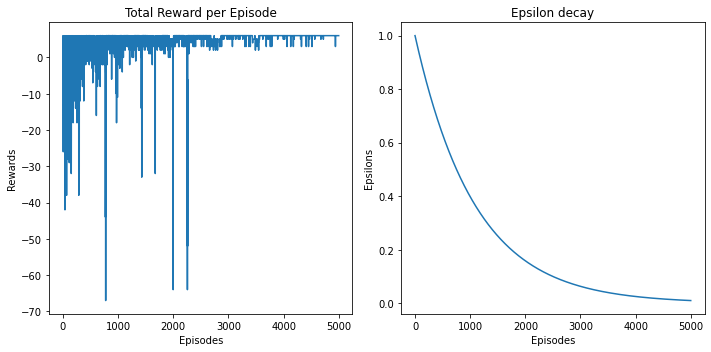

In [54]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y))
plt.plot(xn,y)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(x))
plt.plot(x1,x)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

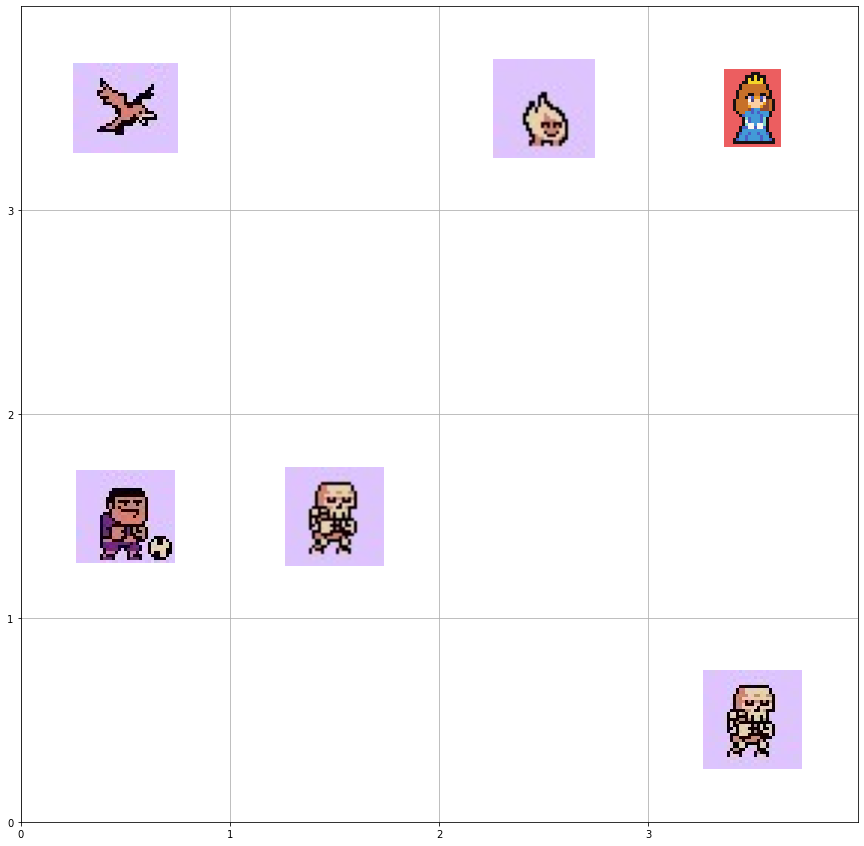

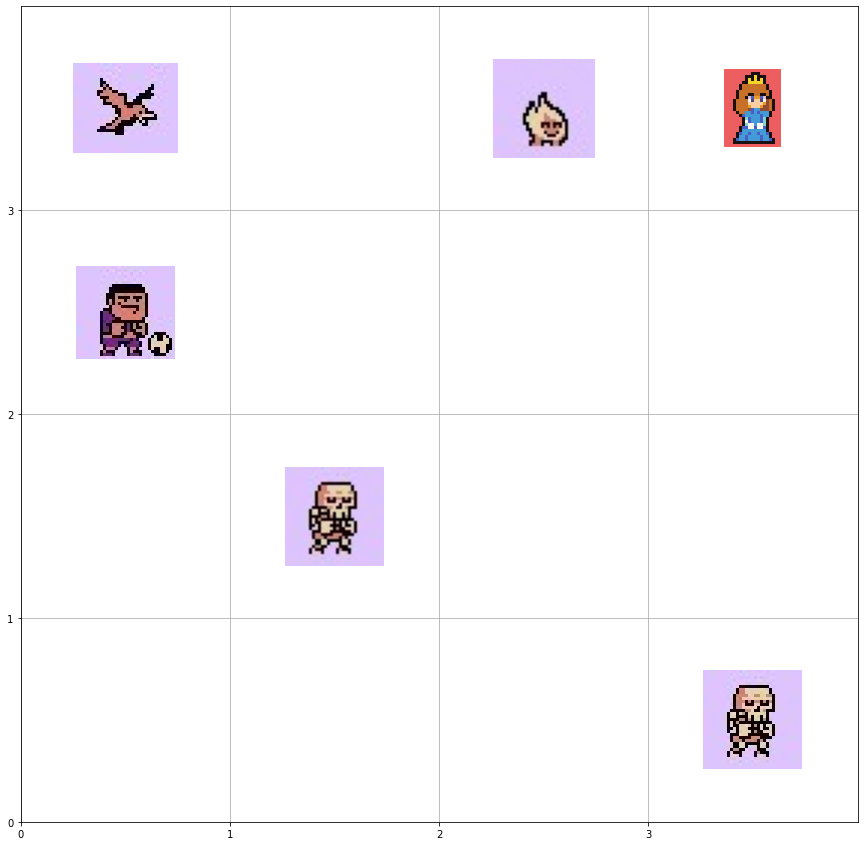

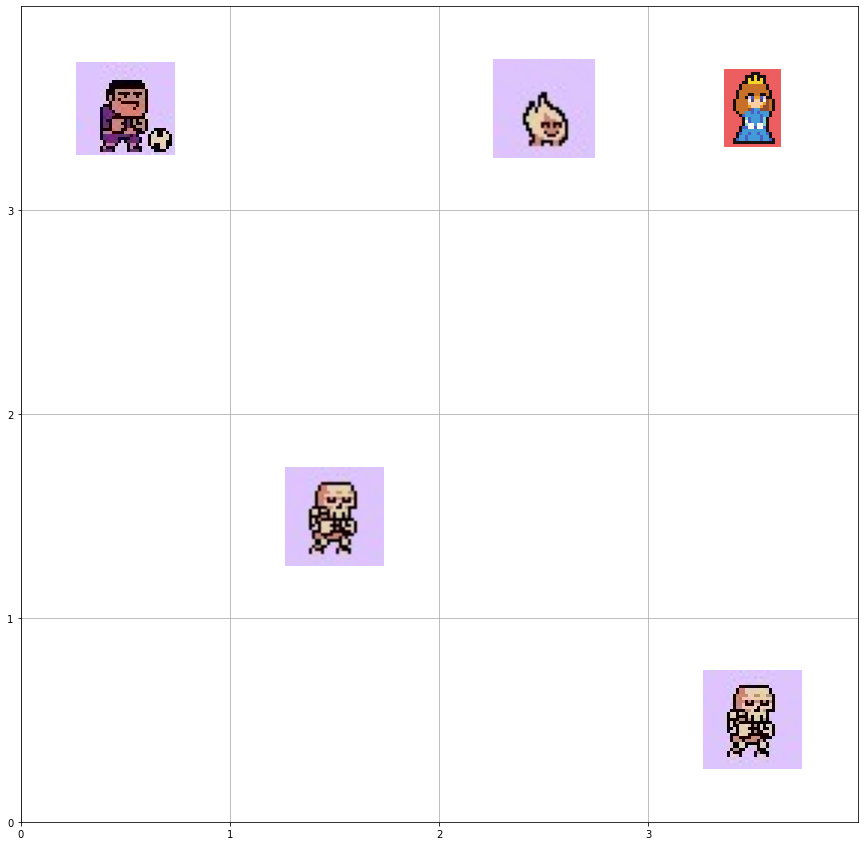

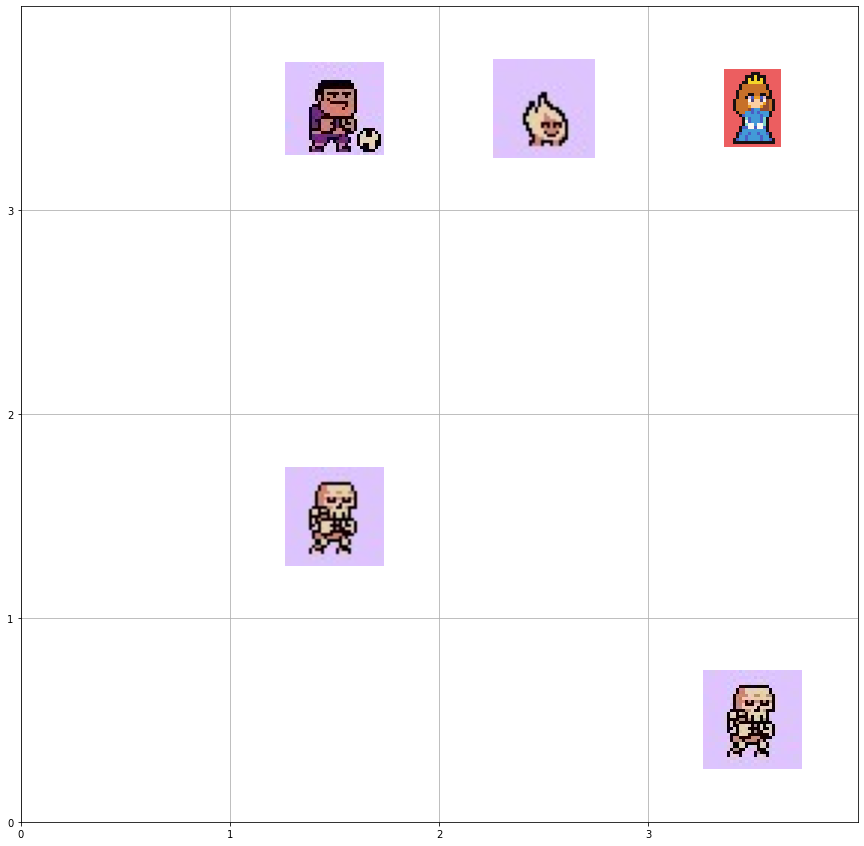

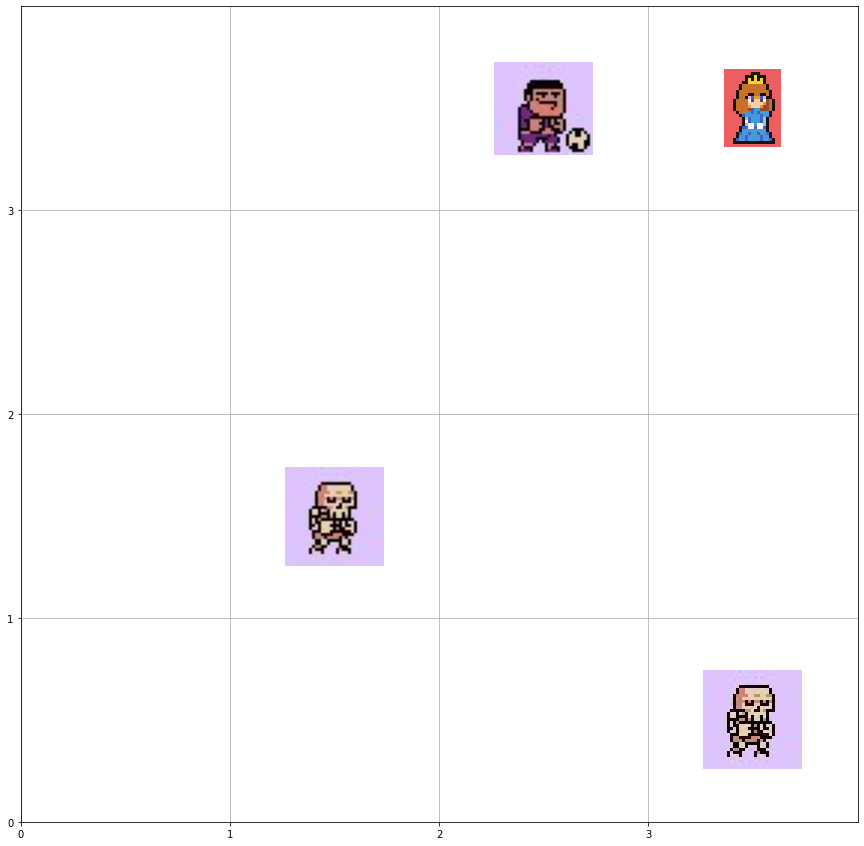

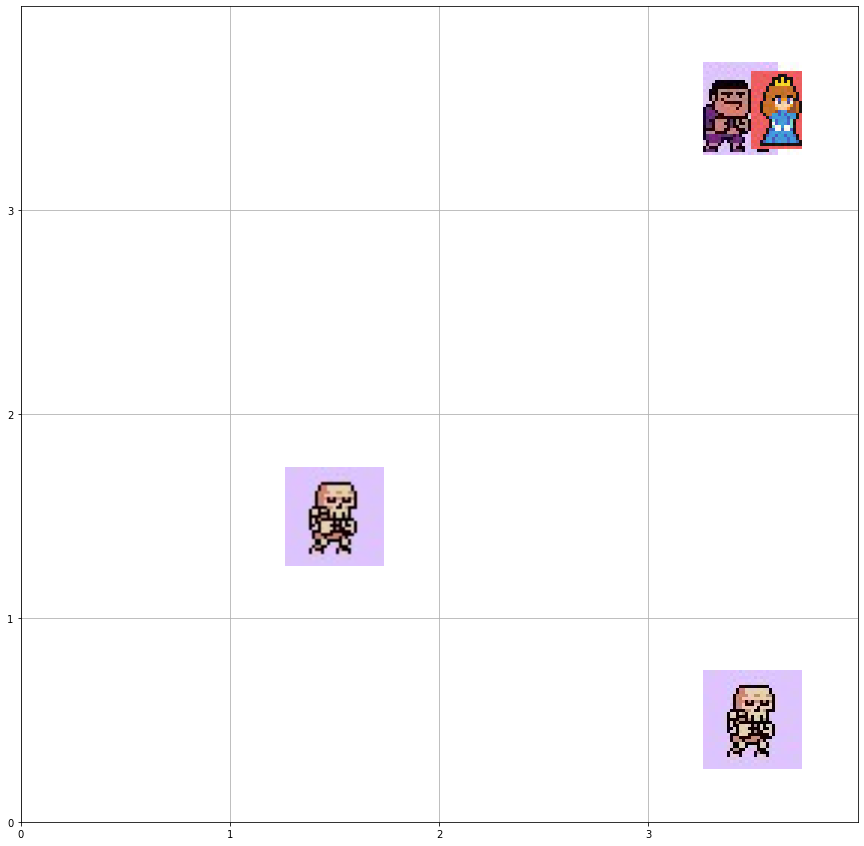

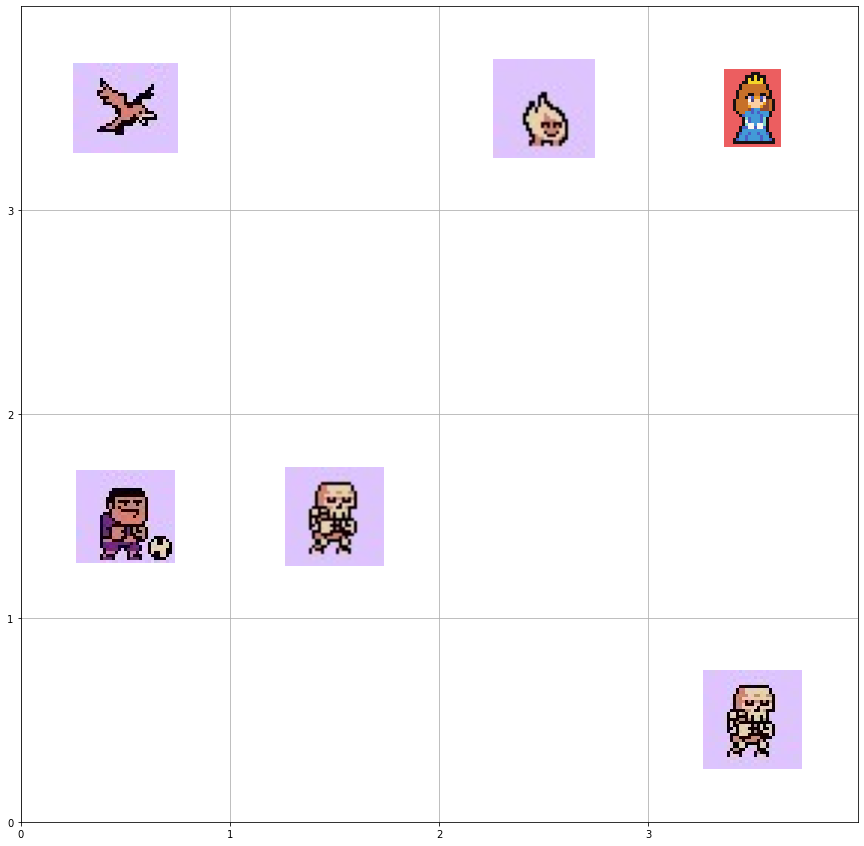

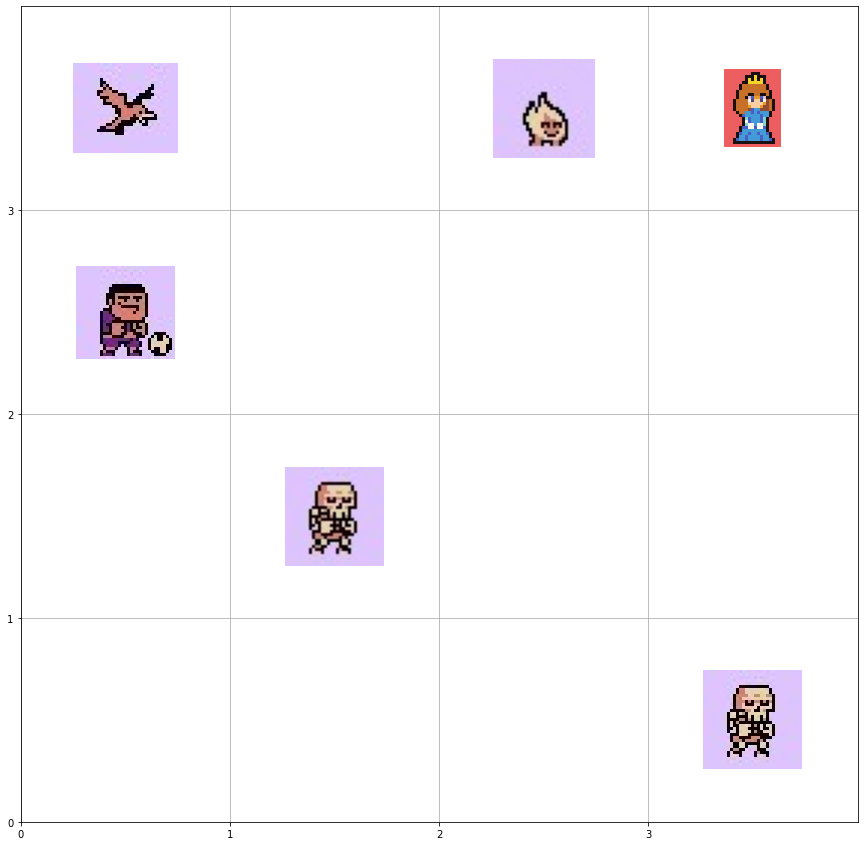

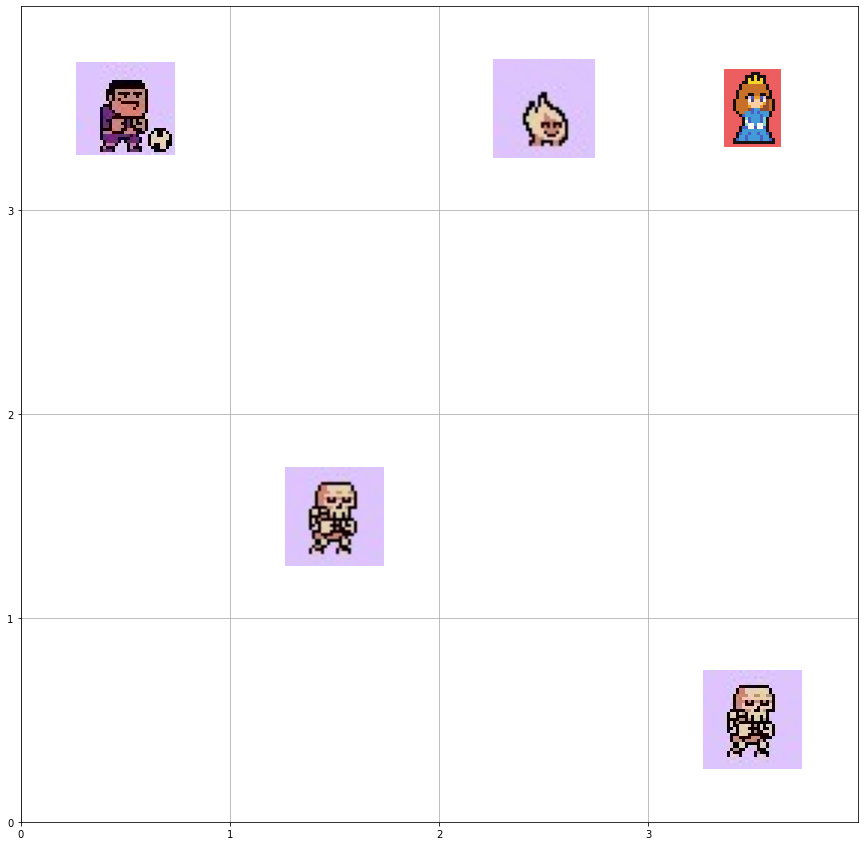

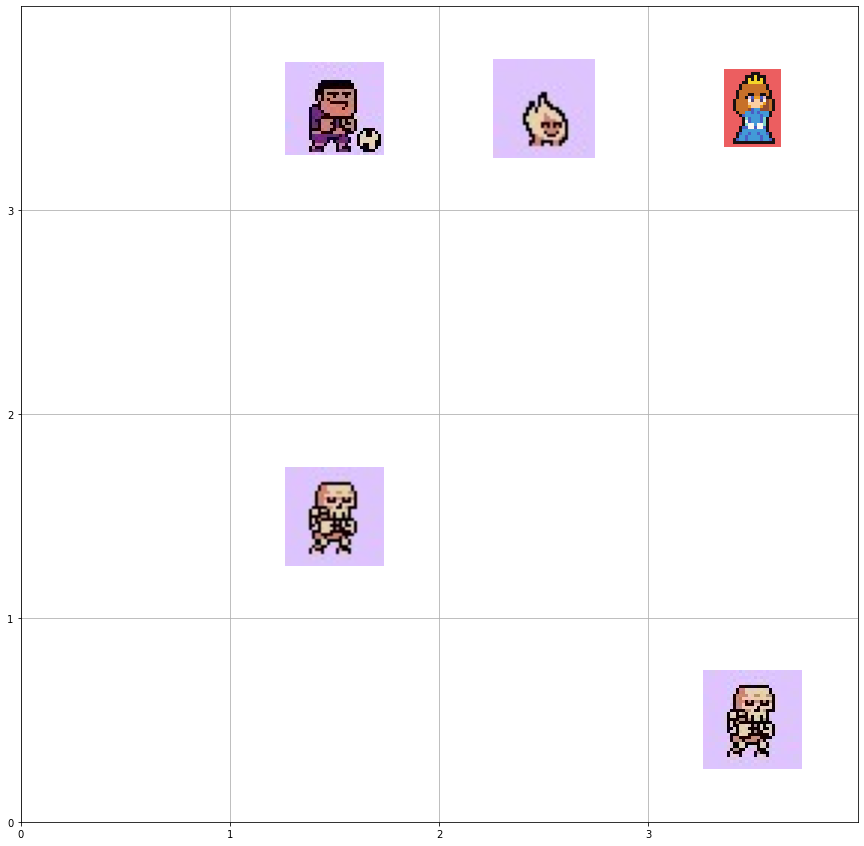

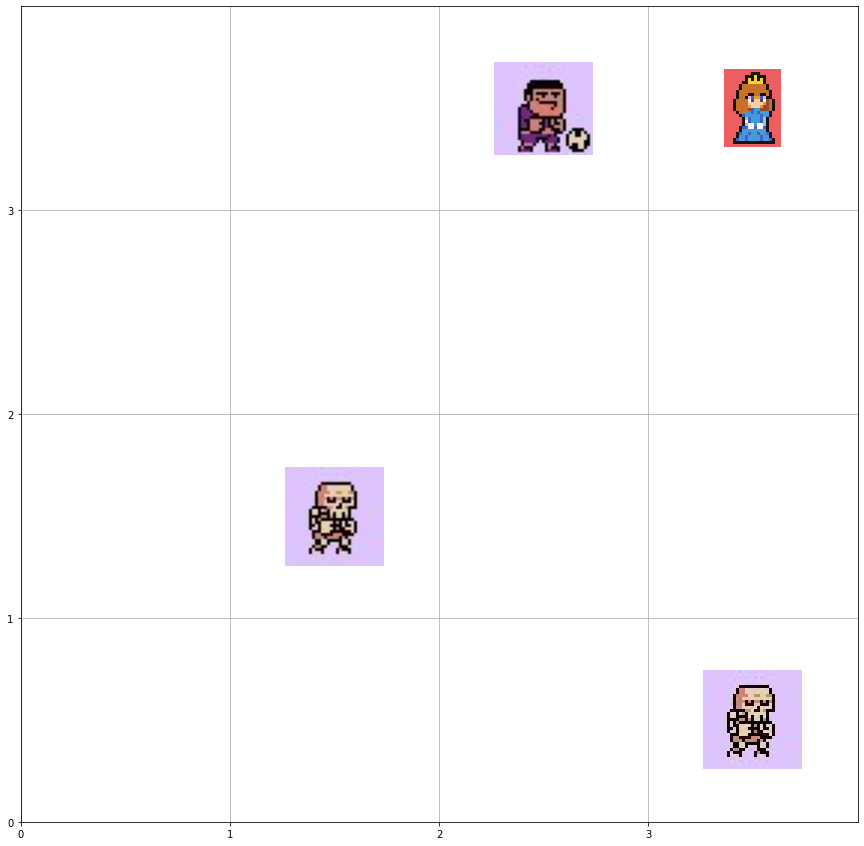

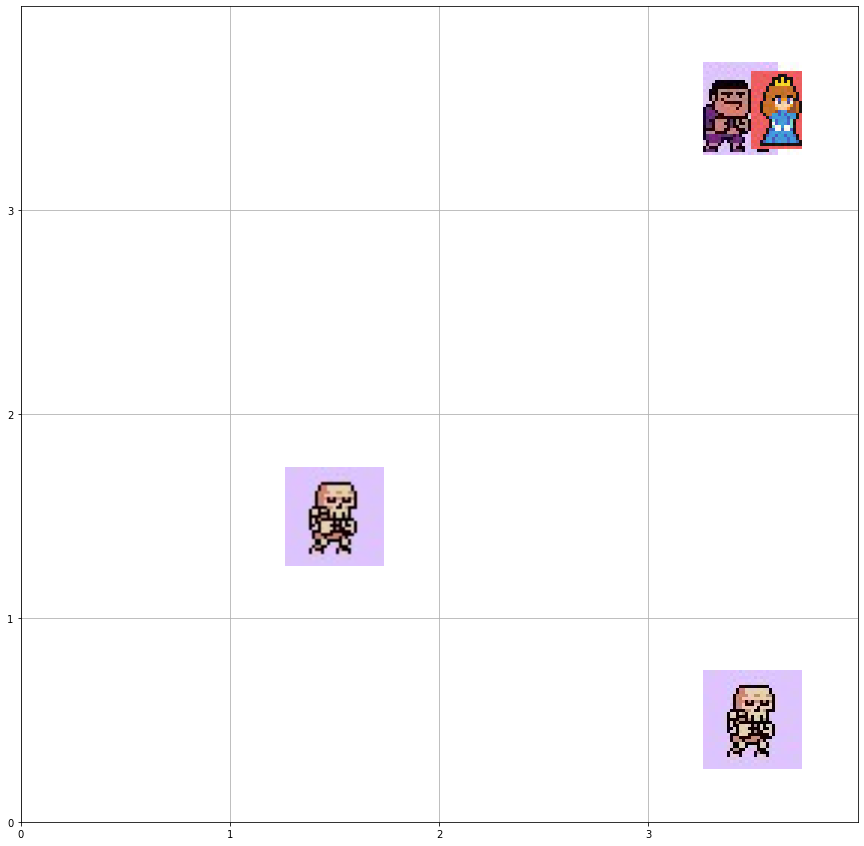

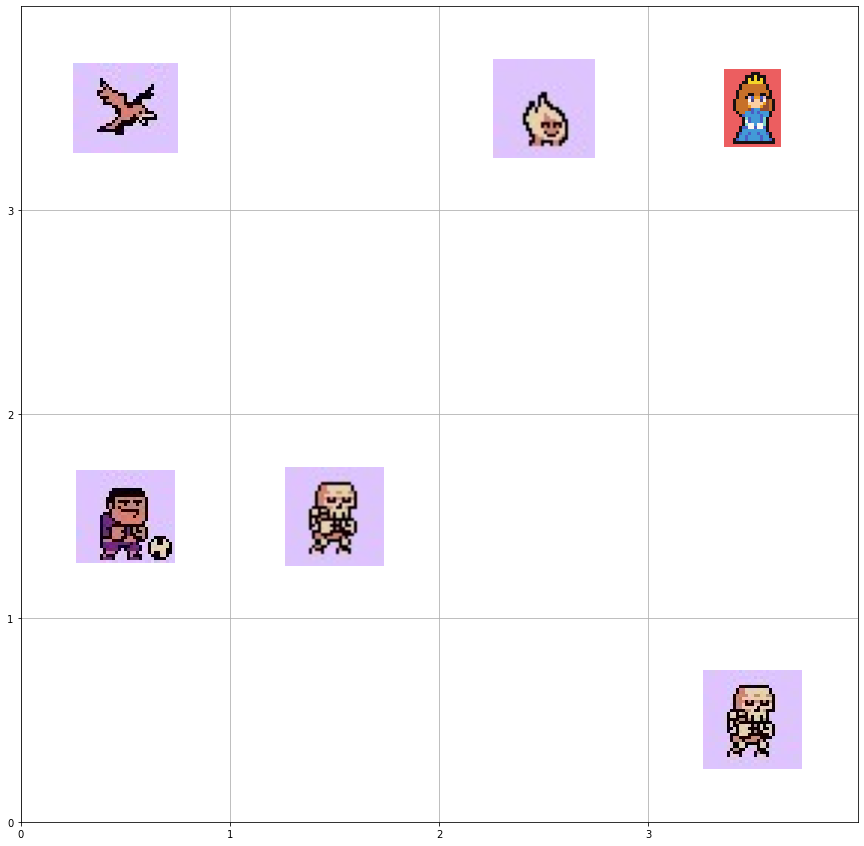

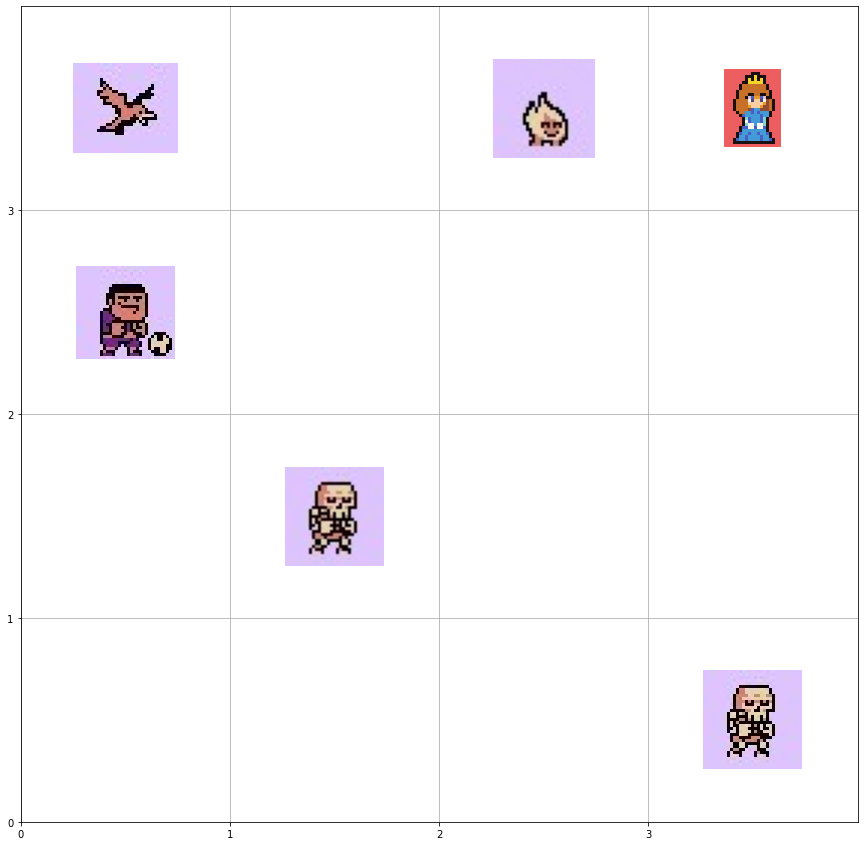

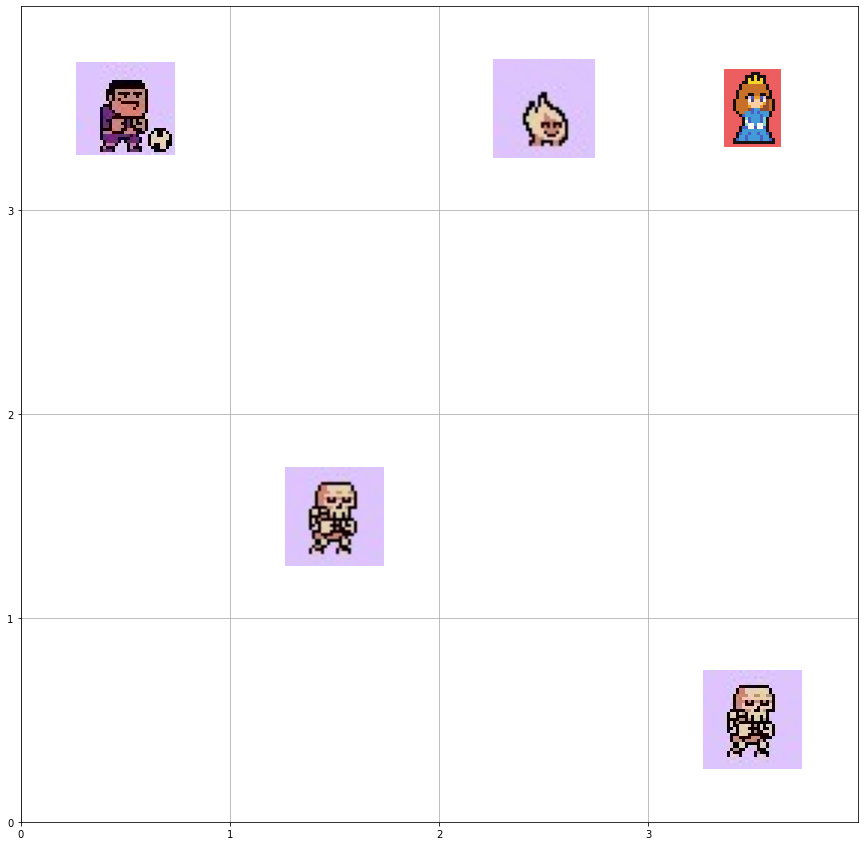

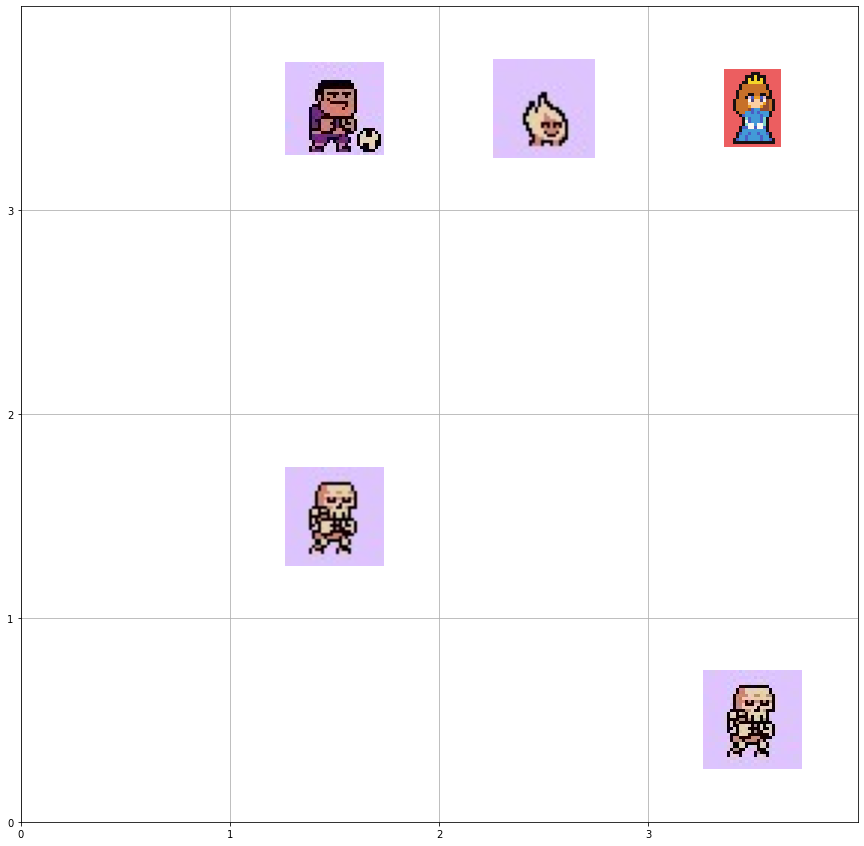

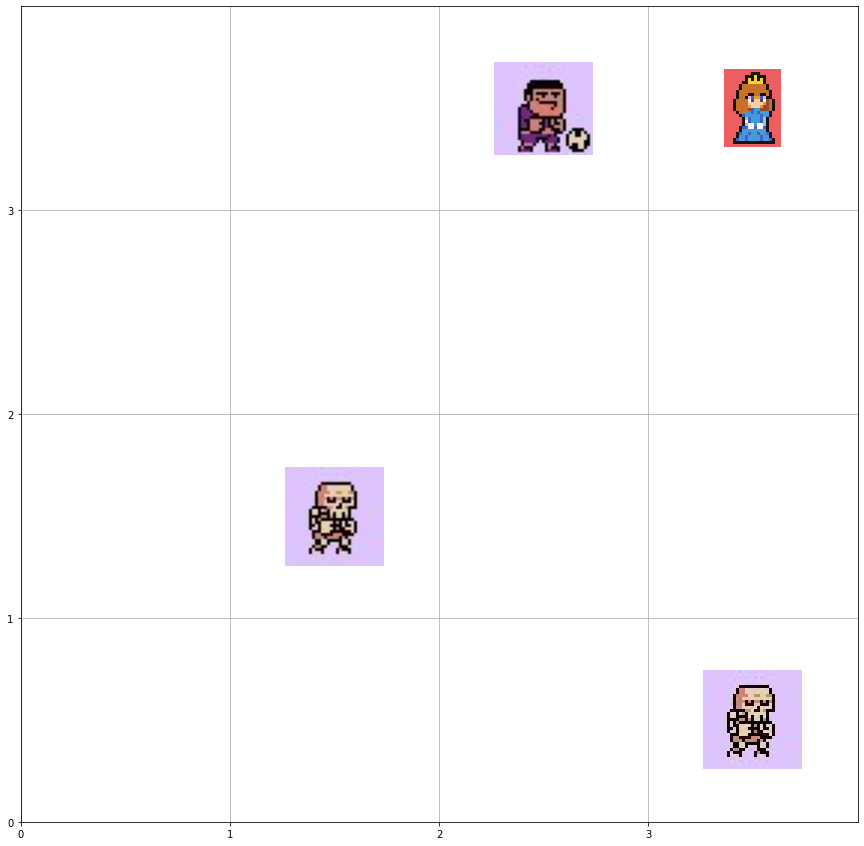

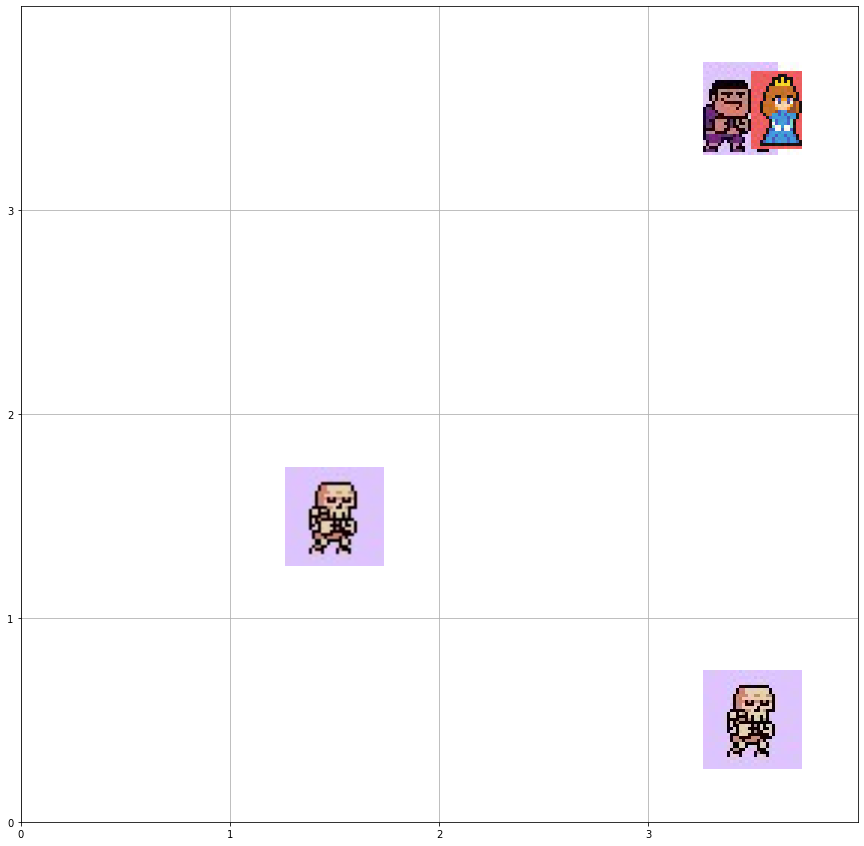

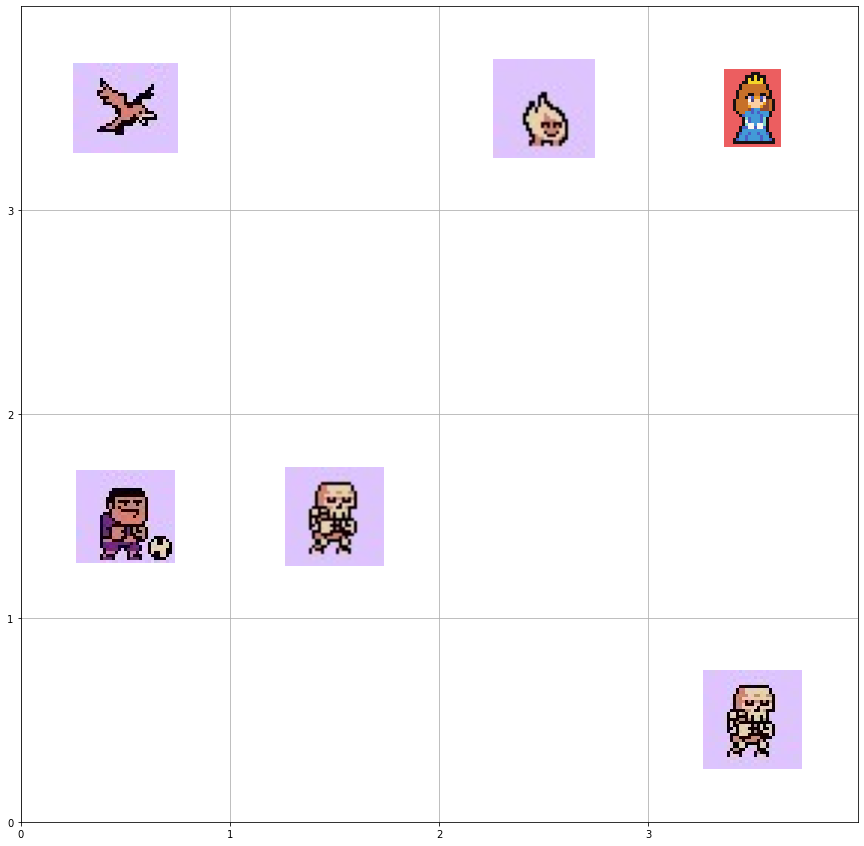

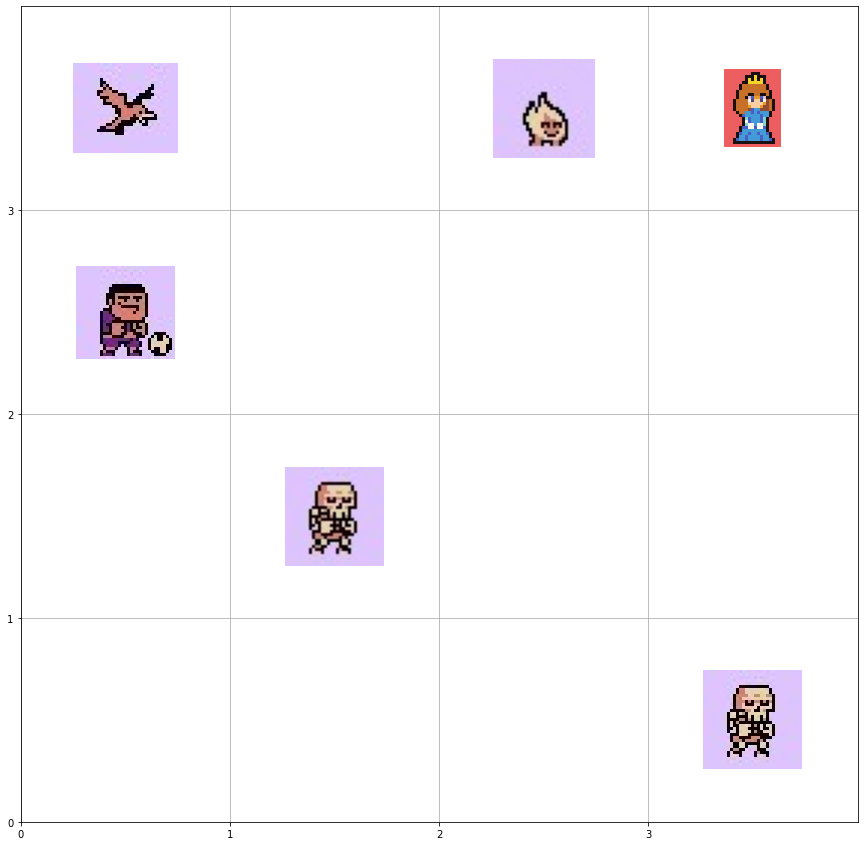

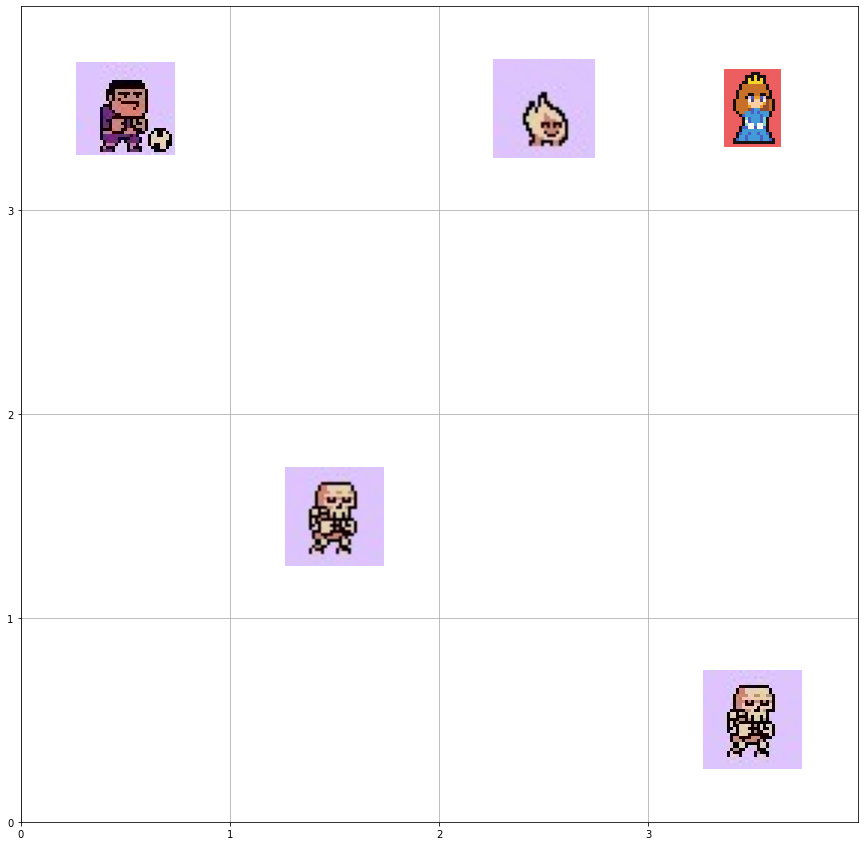

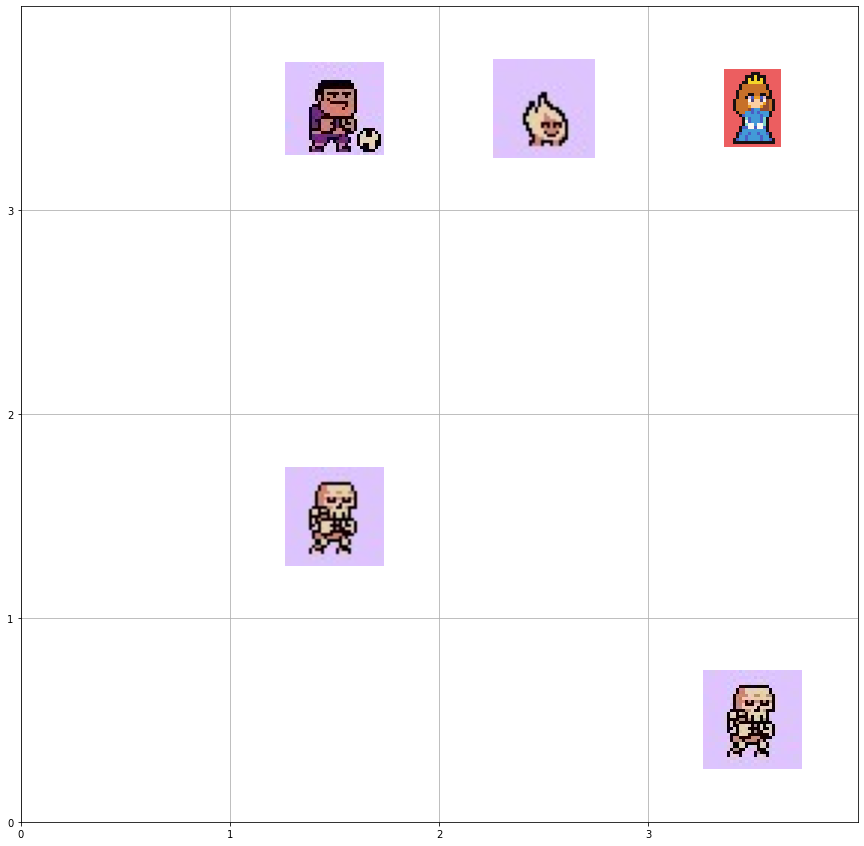

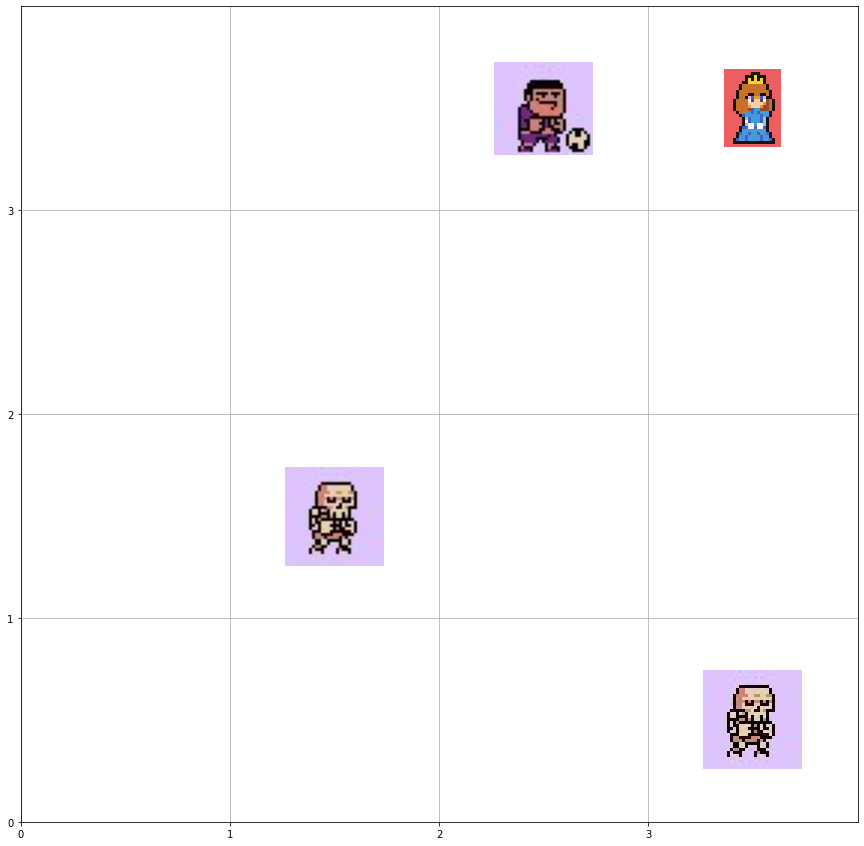

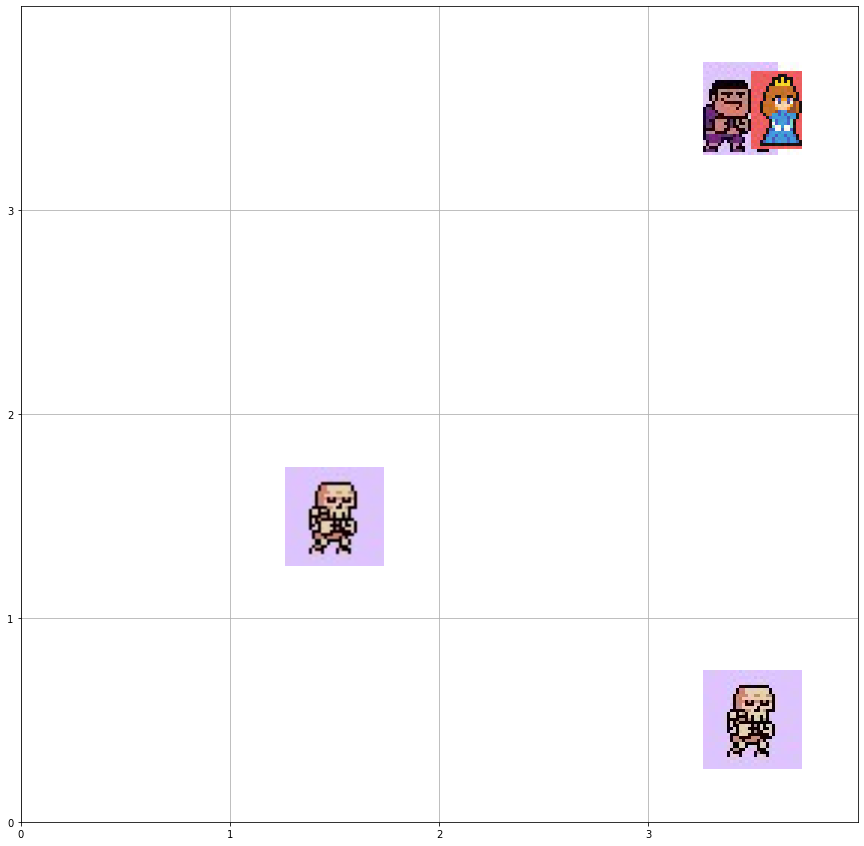

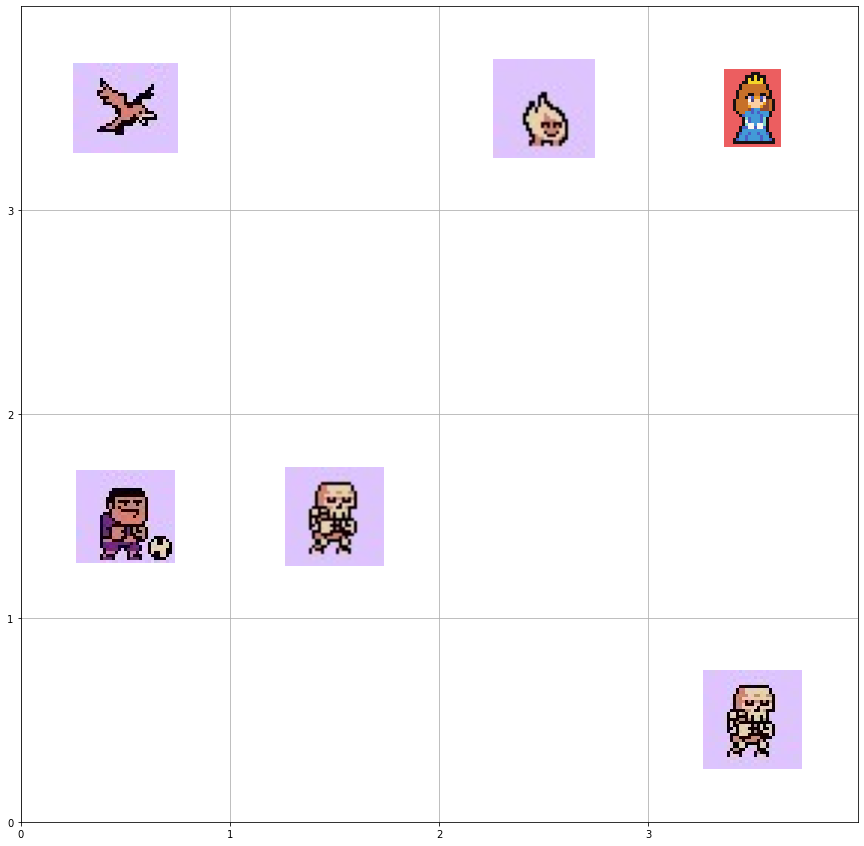

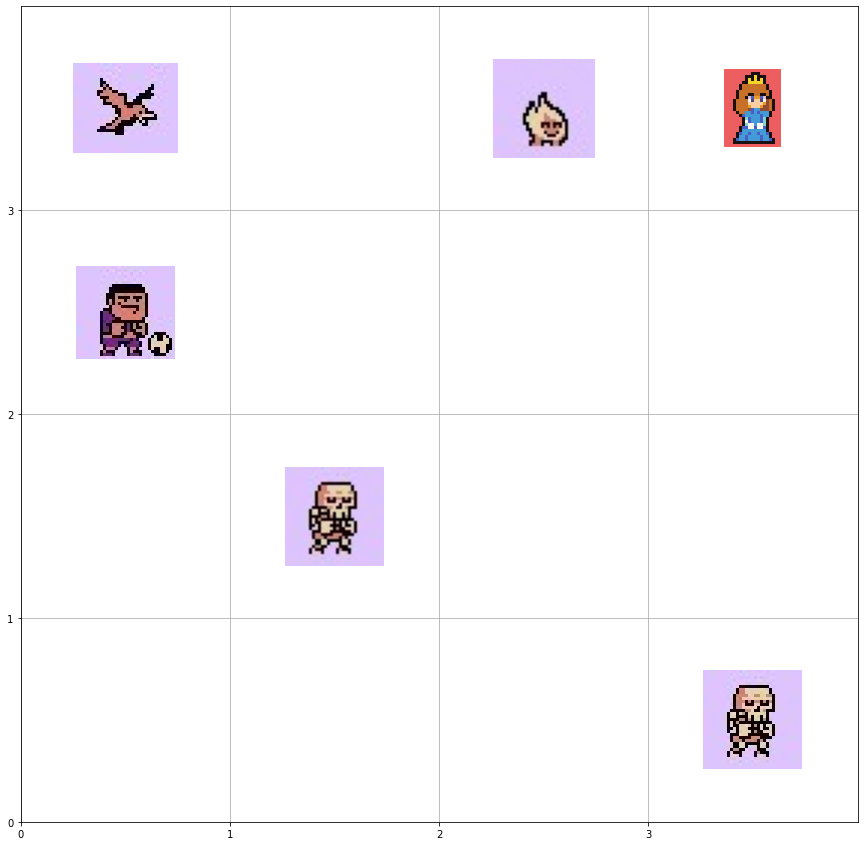

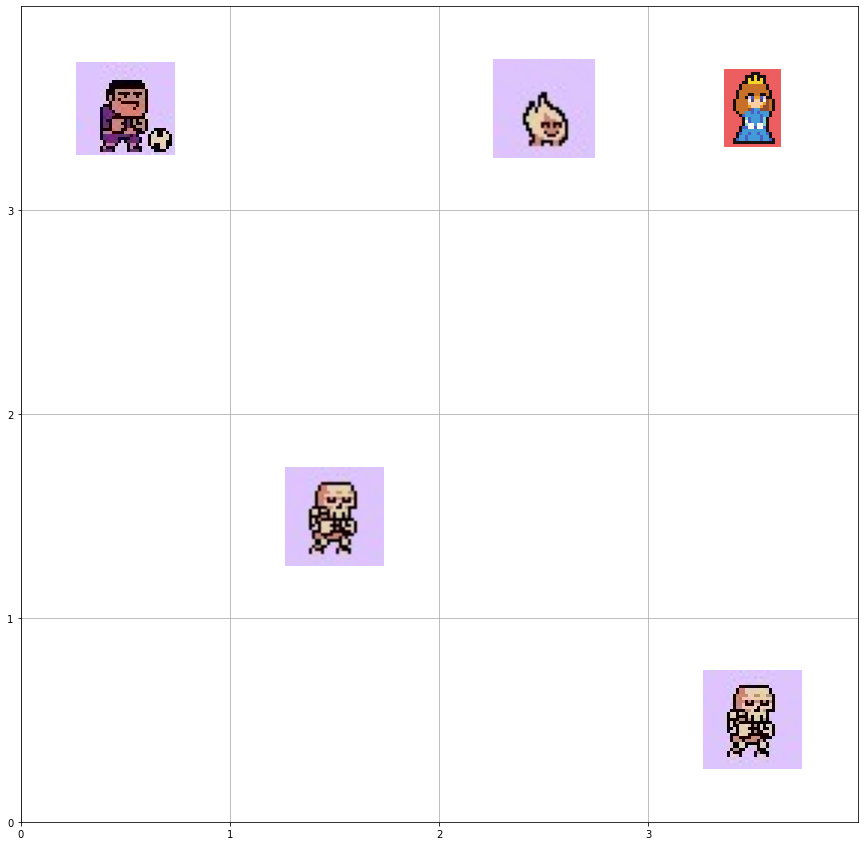

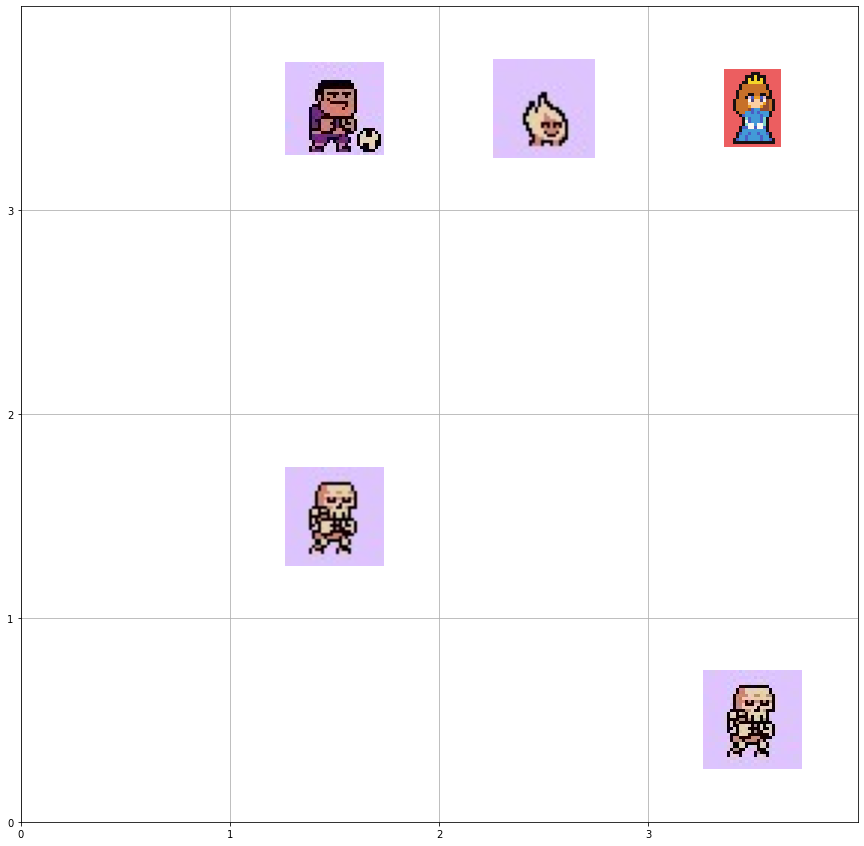

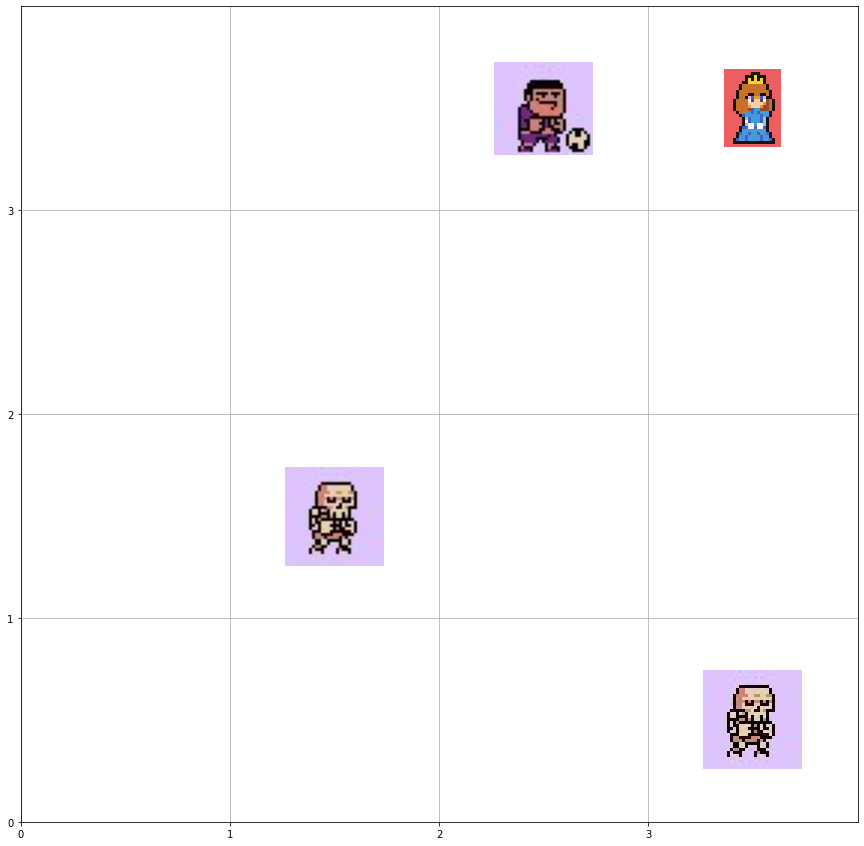

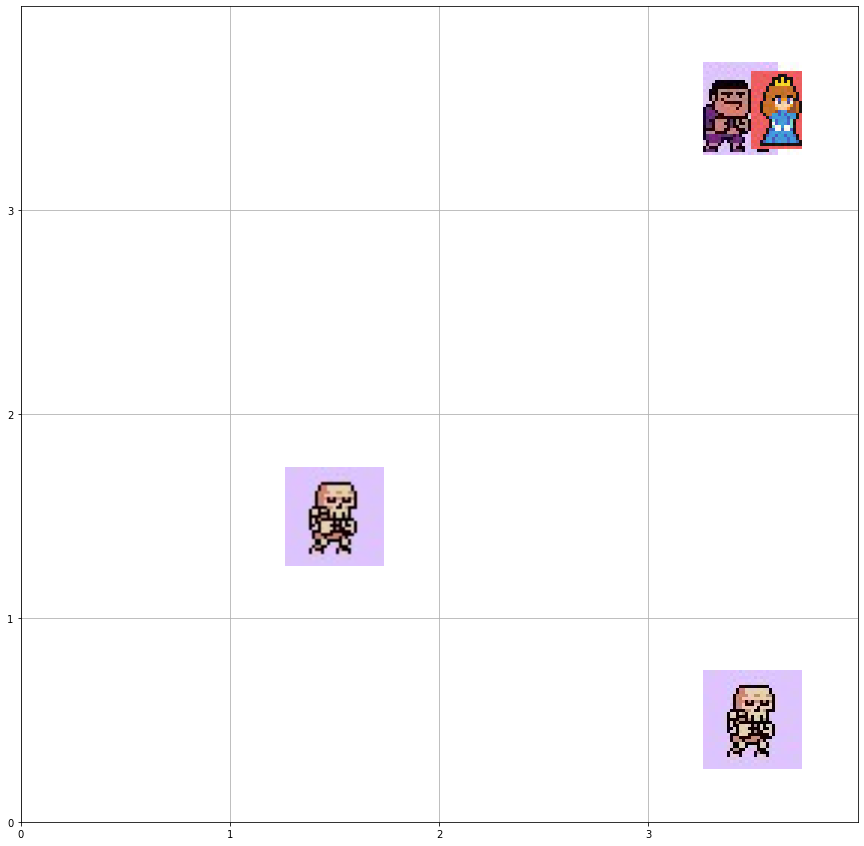

In [55]:
sd = evaluate_model(env, agent, model, 5)

**Reward per Episode**

Text(0.5, 0, 'Episodes')

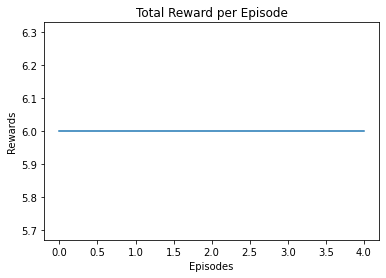

In [56]:
x = range(len(sd))
plt.plot(x,sd)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')

**Double DQN**

In [57]:
x1, y1, model1 = train_model(env, agent, DQNmodel,exp, 1, epochs, replay_size, batch_size,100, 0.001,1)

**Epsilon Decay and Rewards per episode**

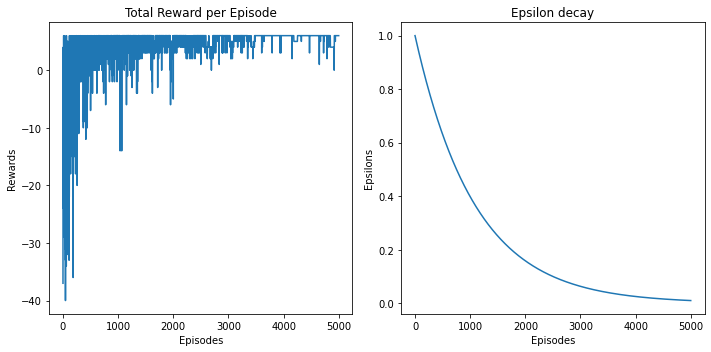

In [58]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y1))
plt.plot(xn,y1)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
xl= range(len(x1))
plt.plot(xl,x1)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

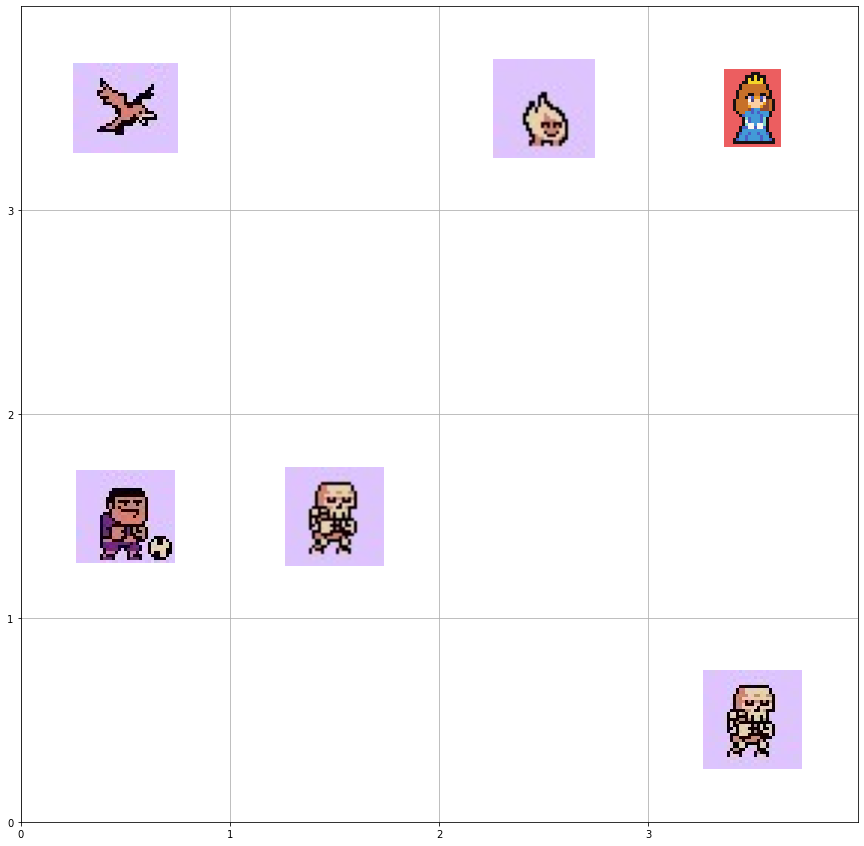

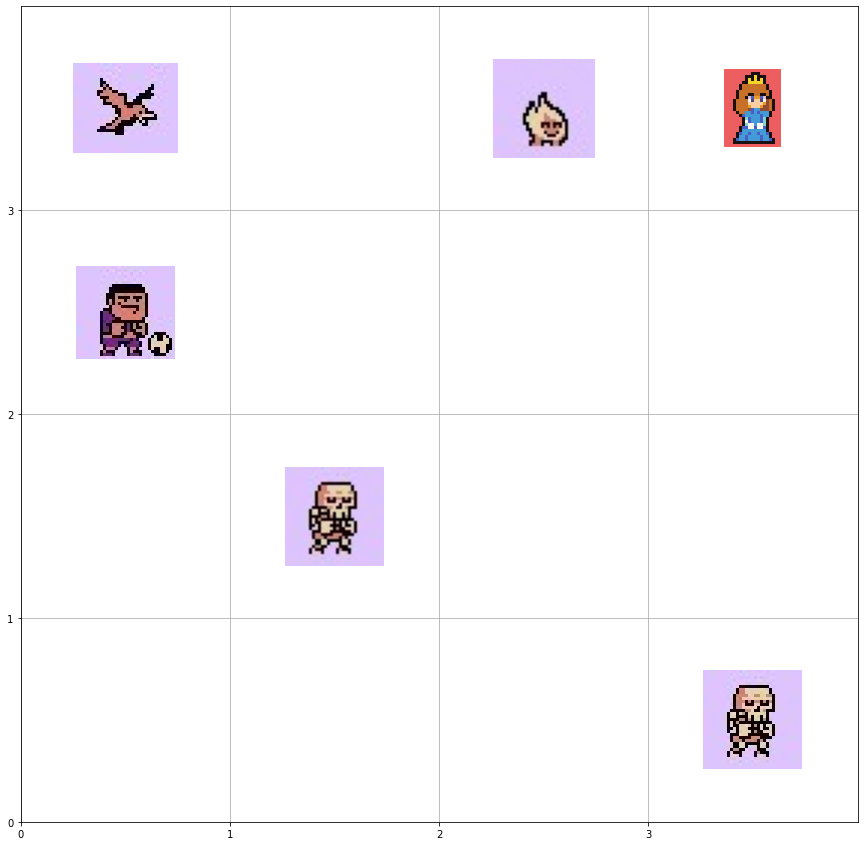

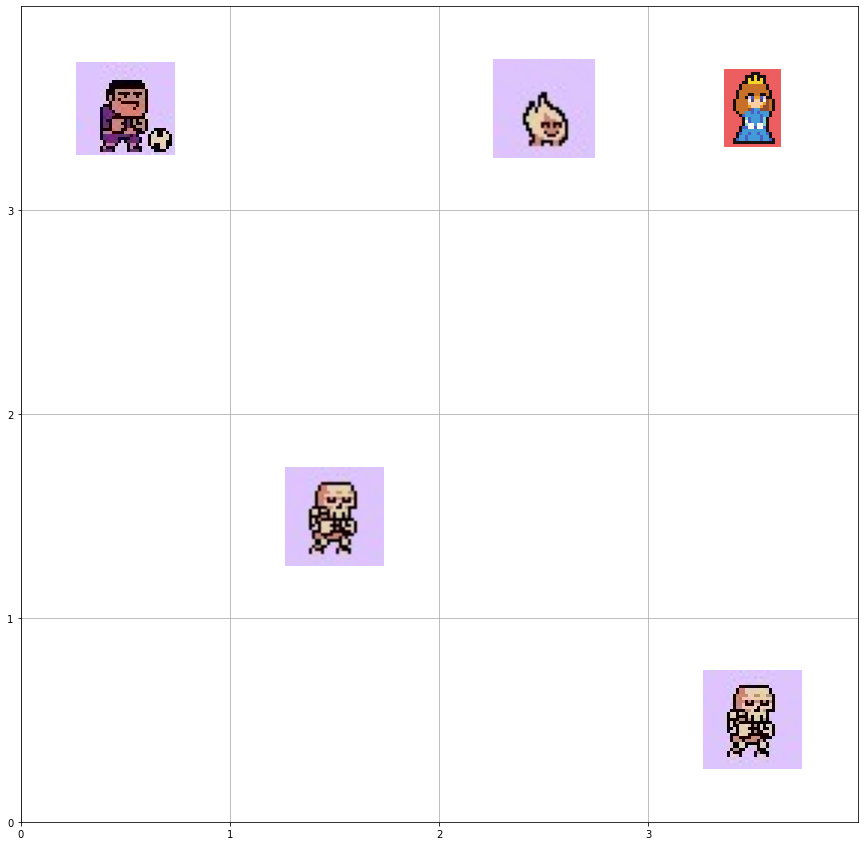

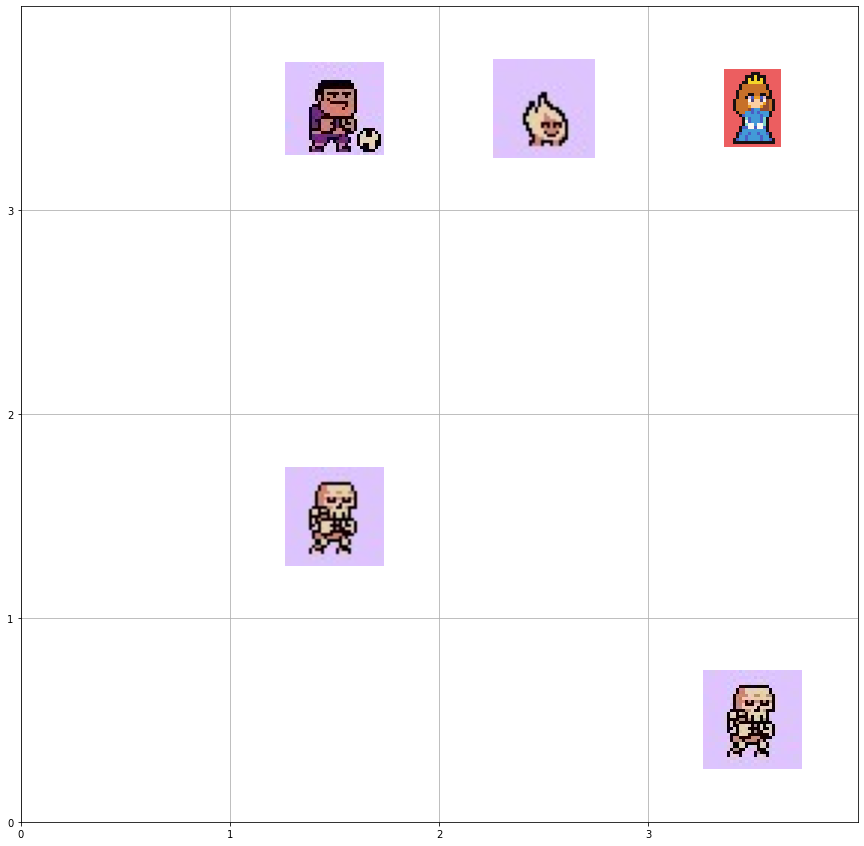

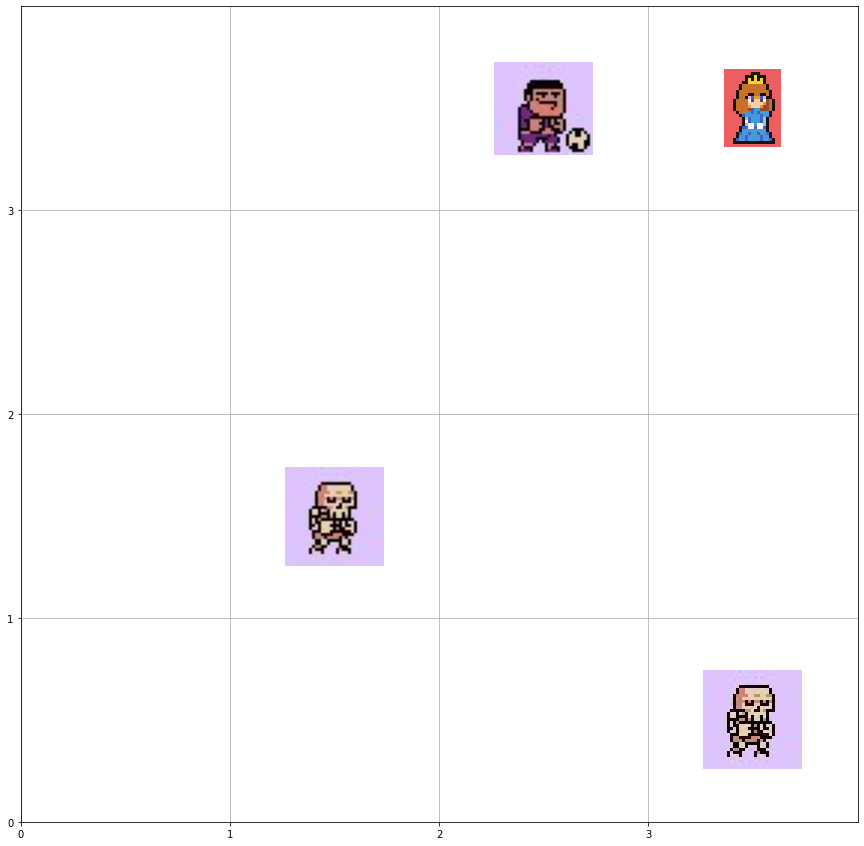

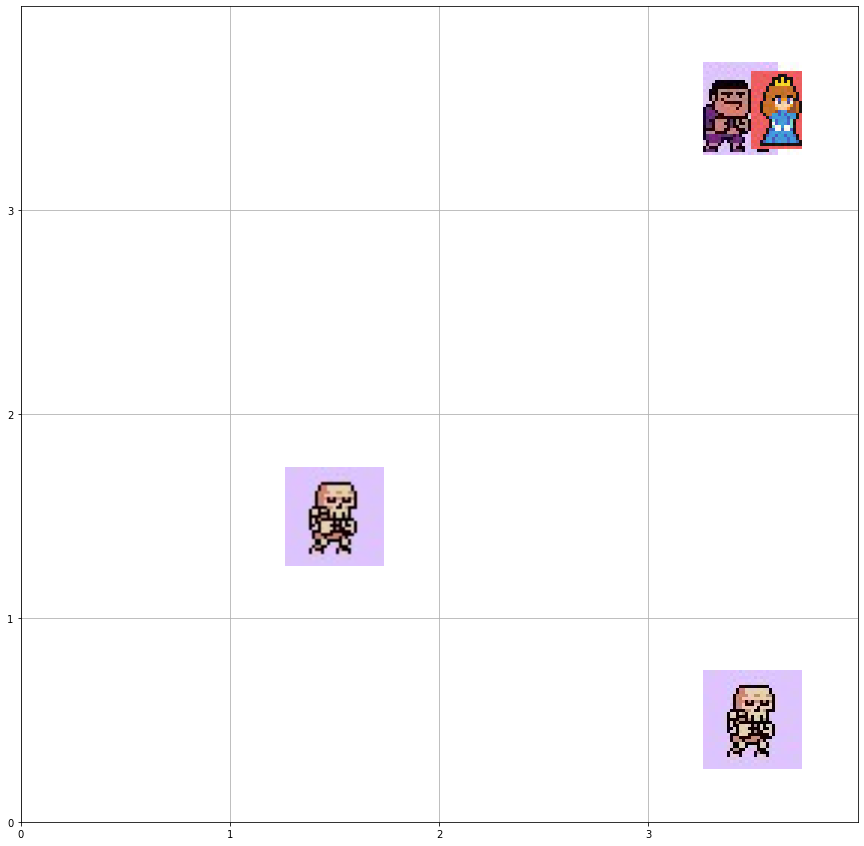

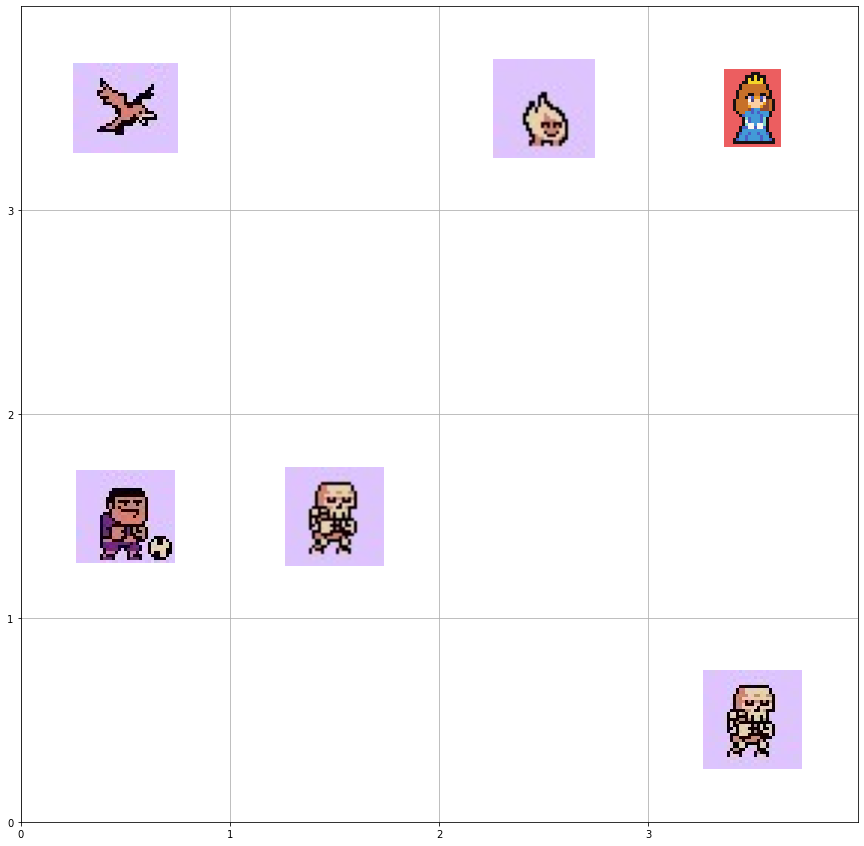

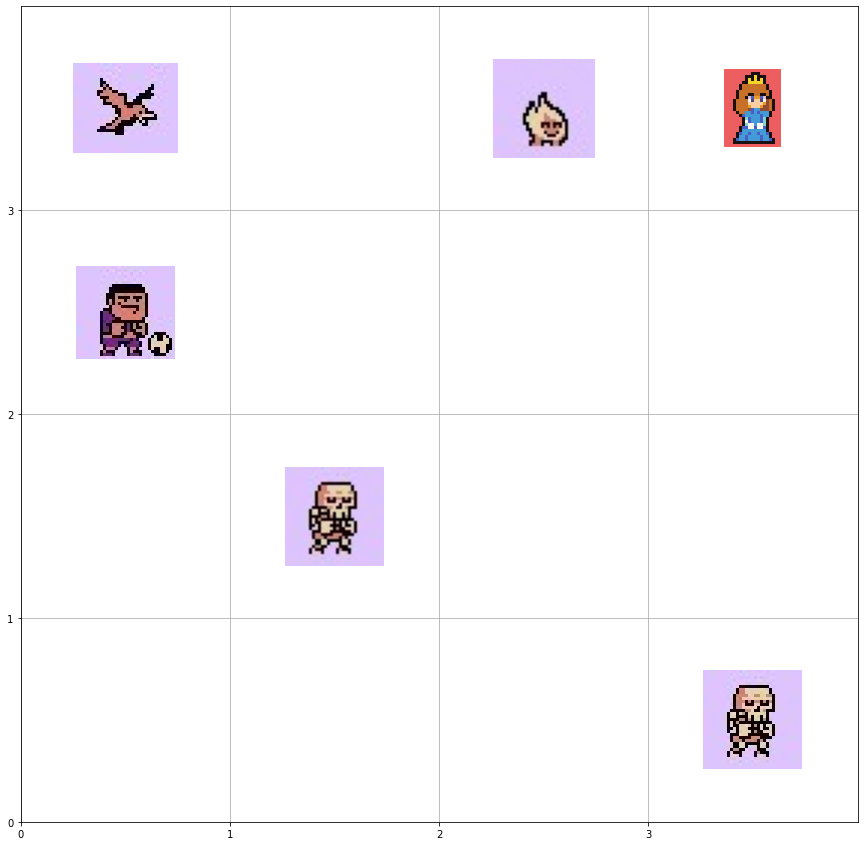

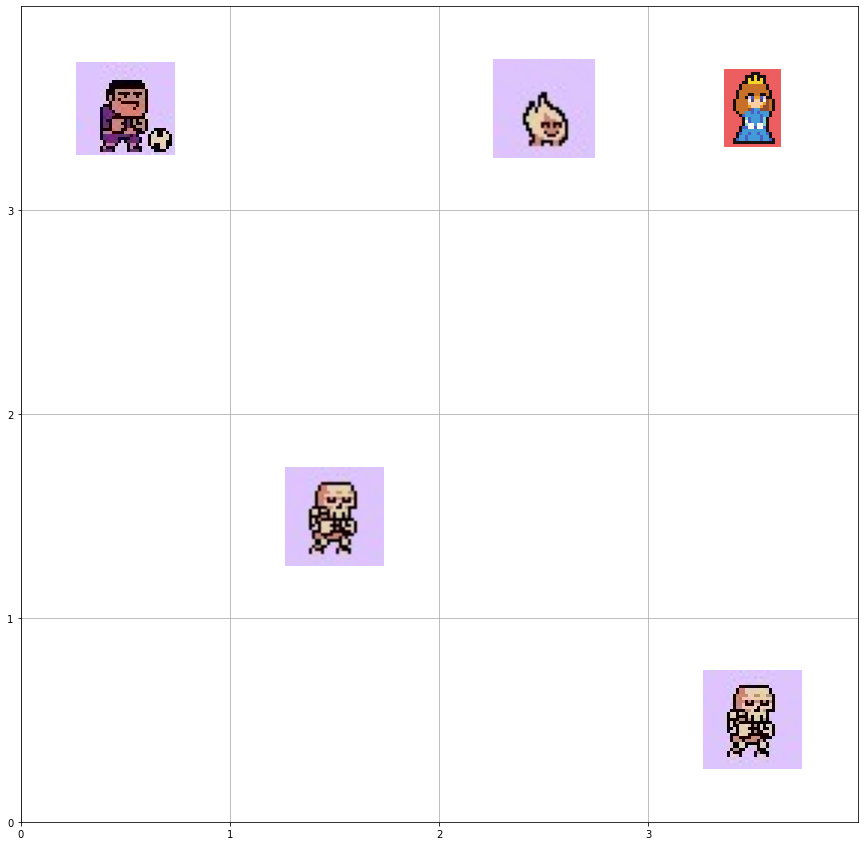

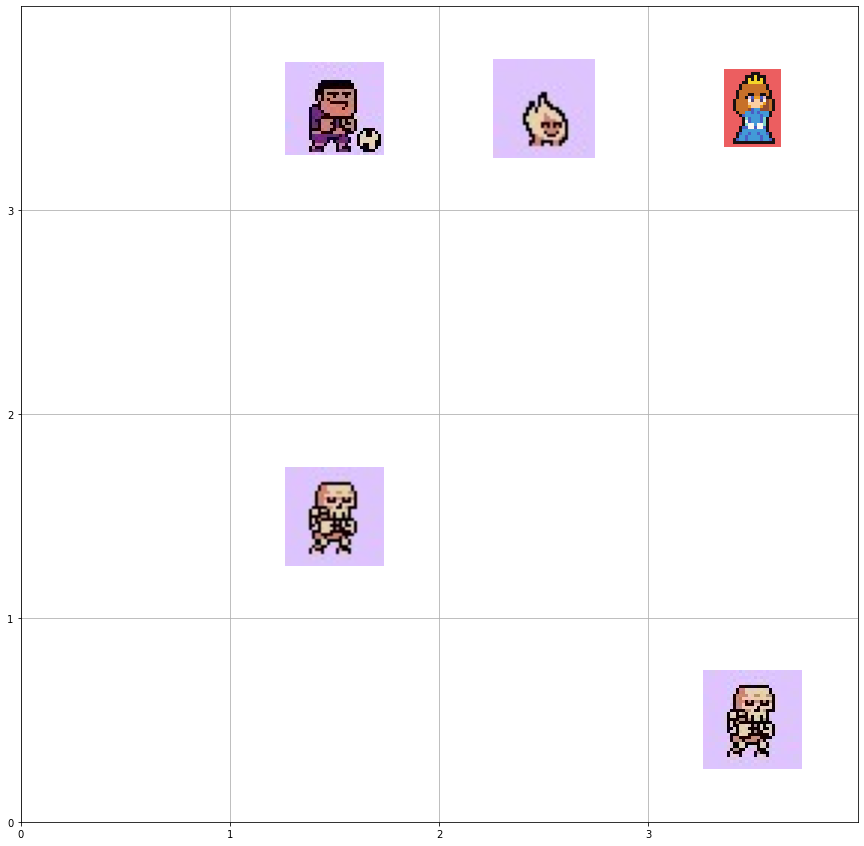

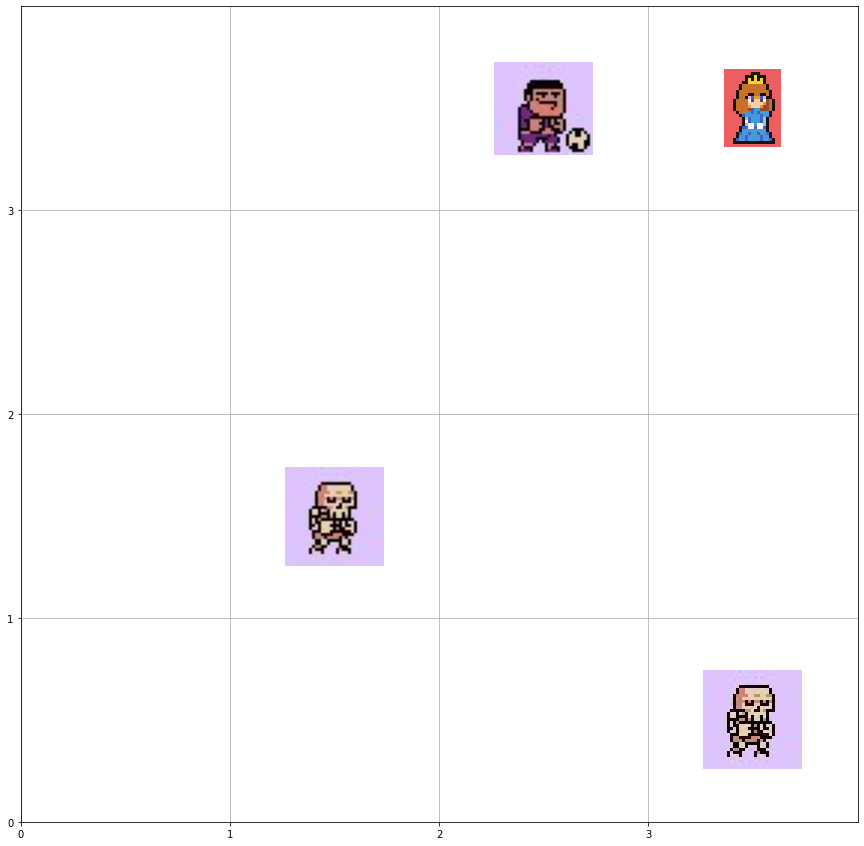

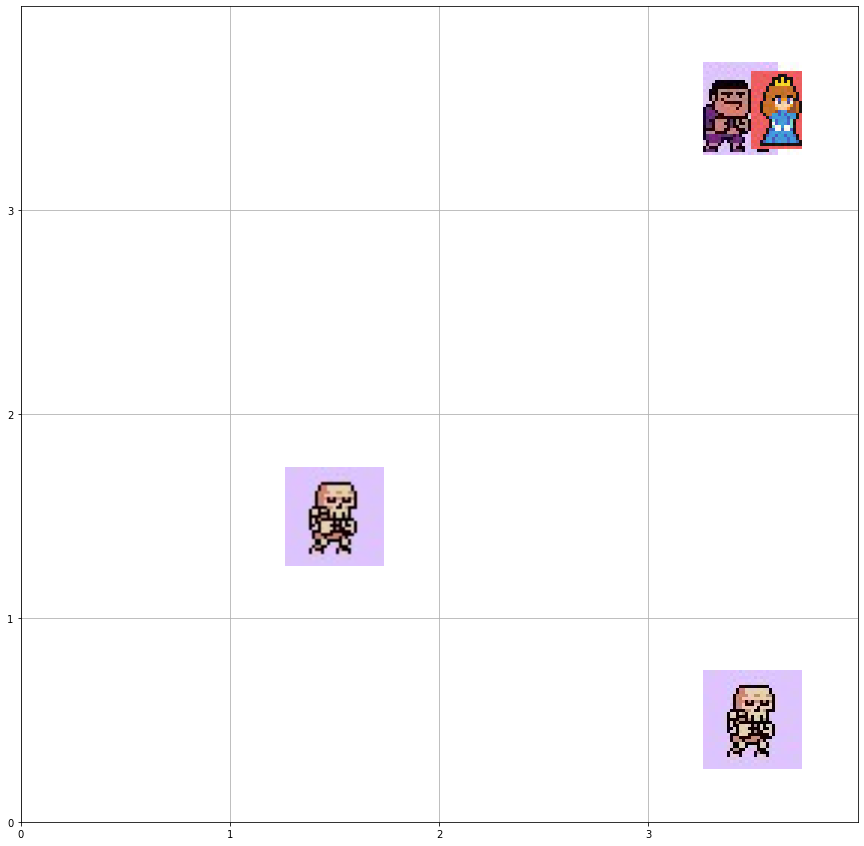

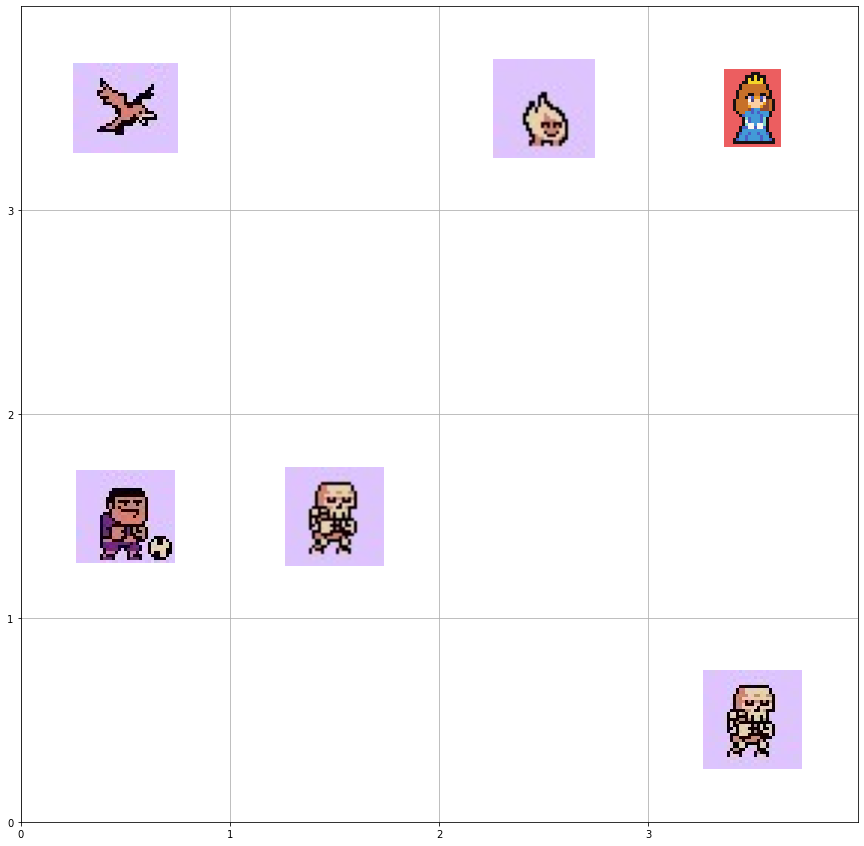

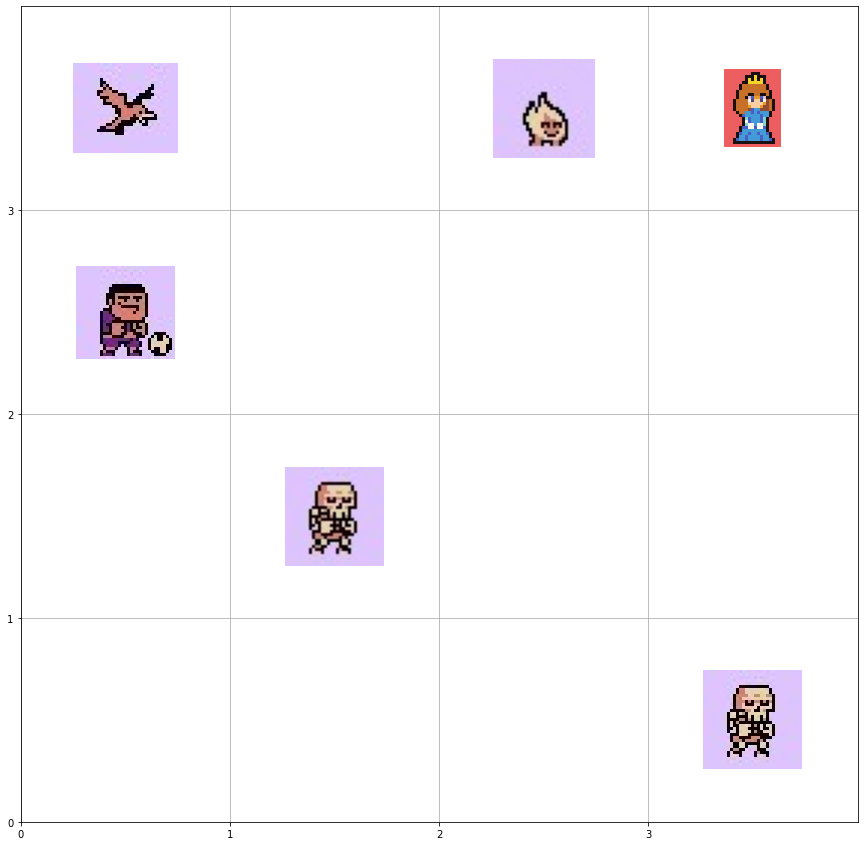

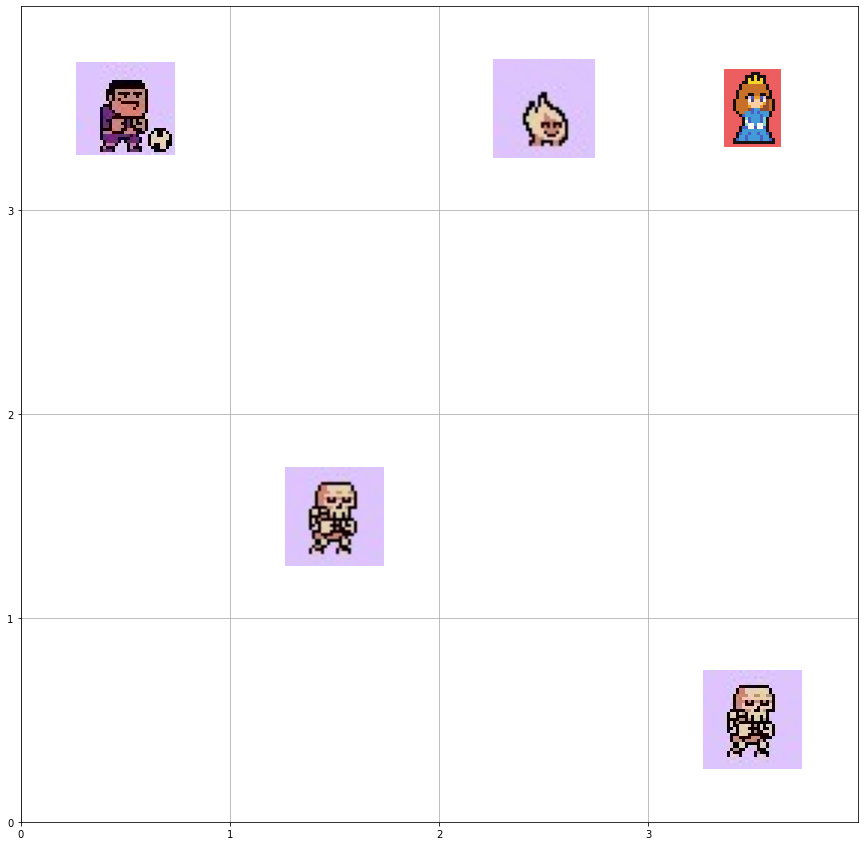

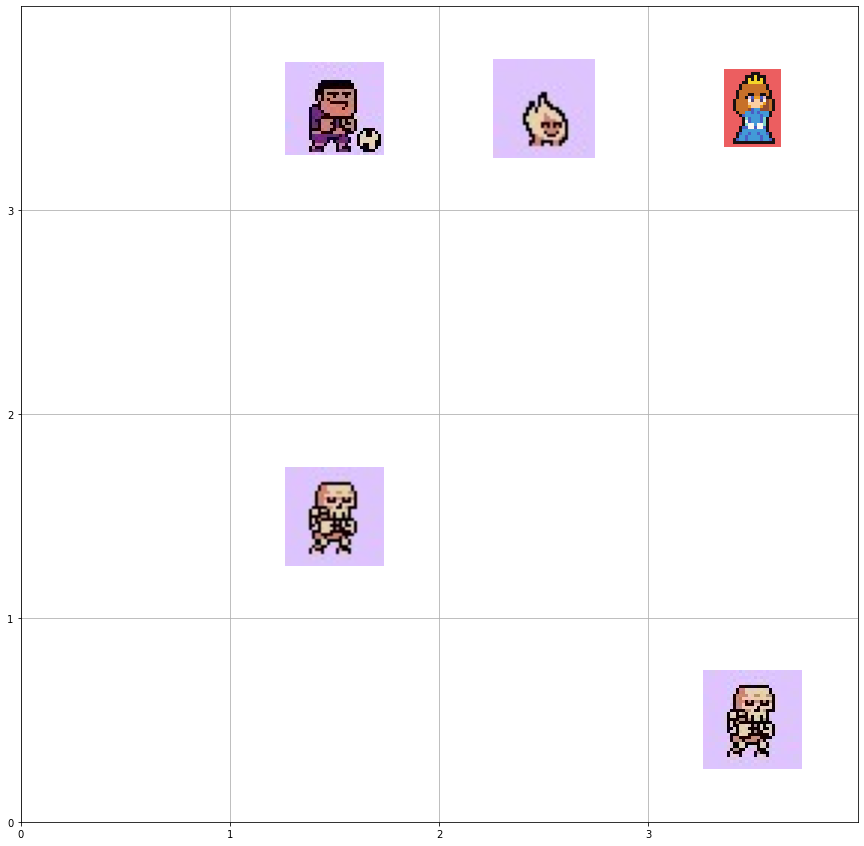

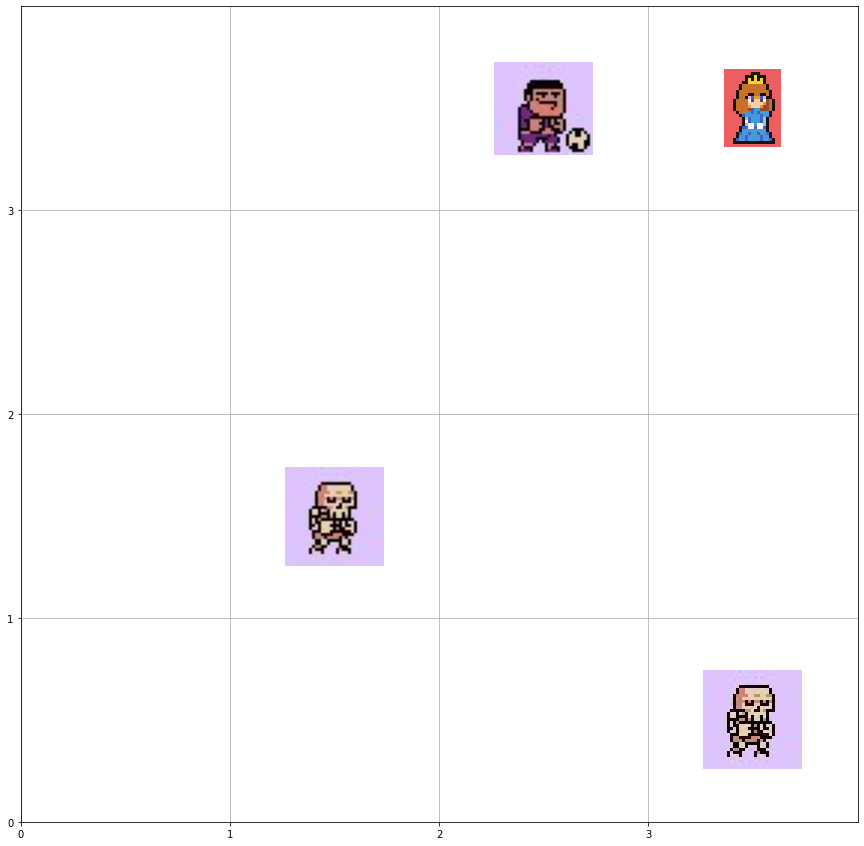

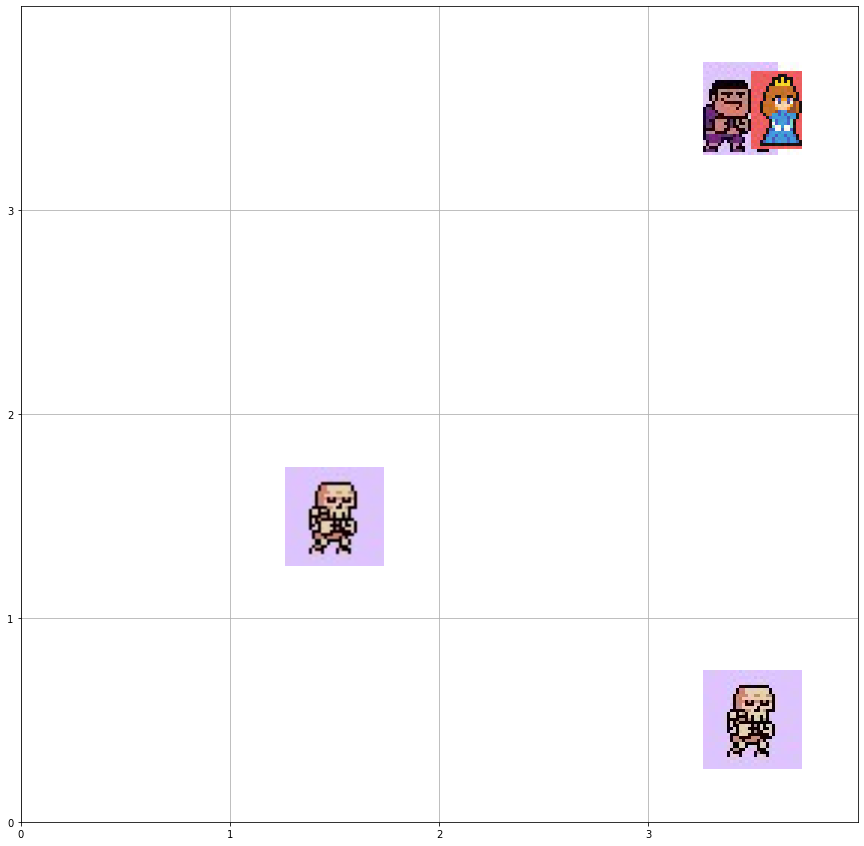

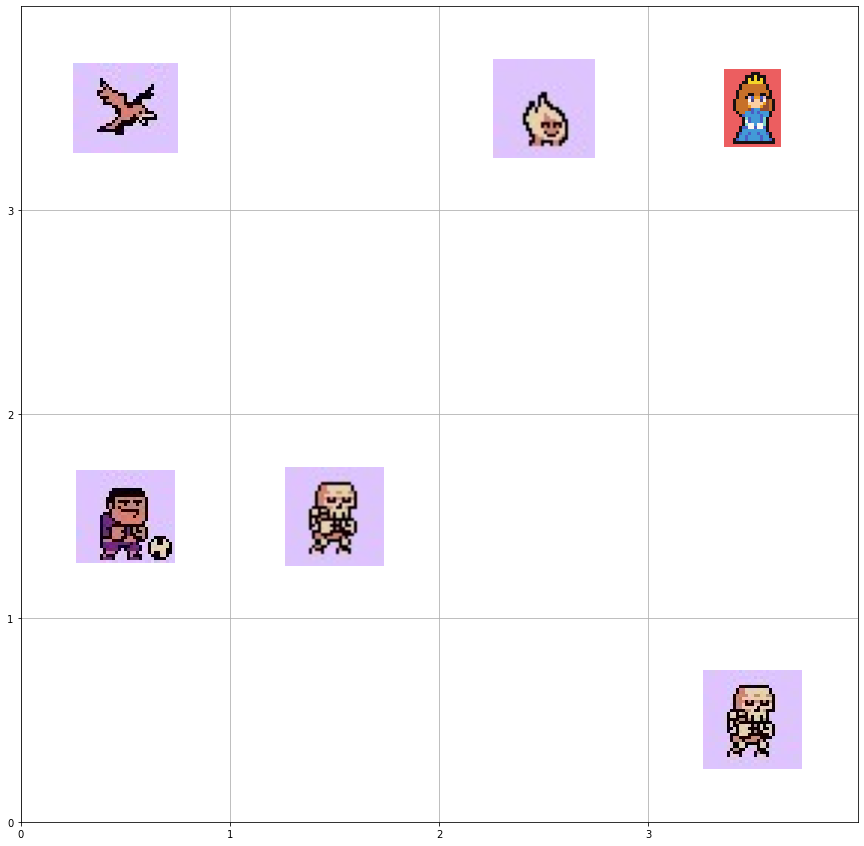

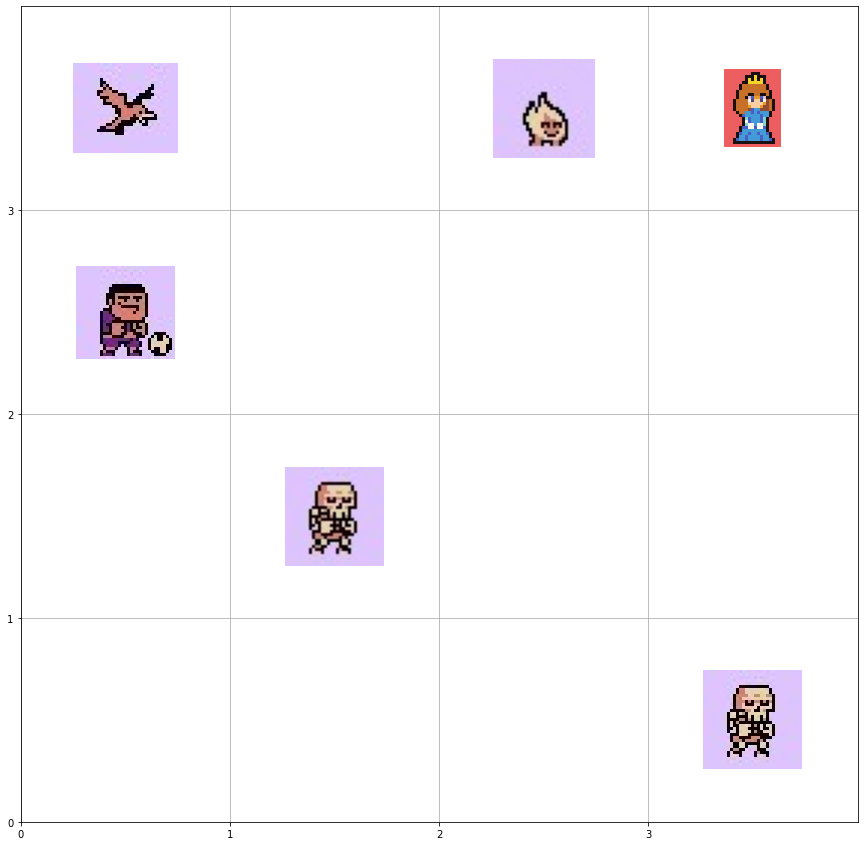

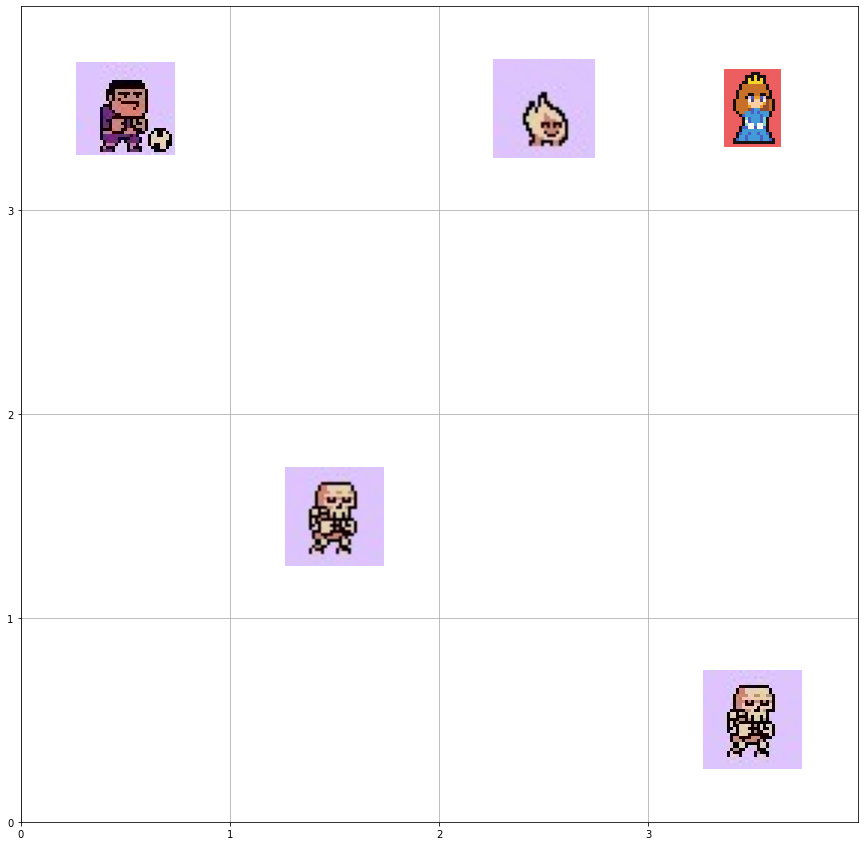

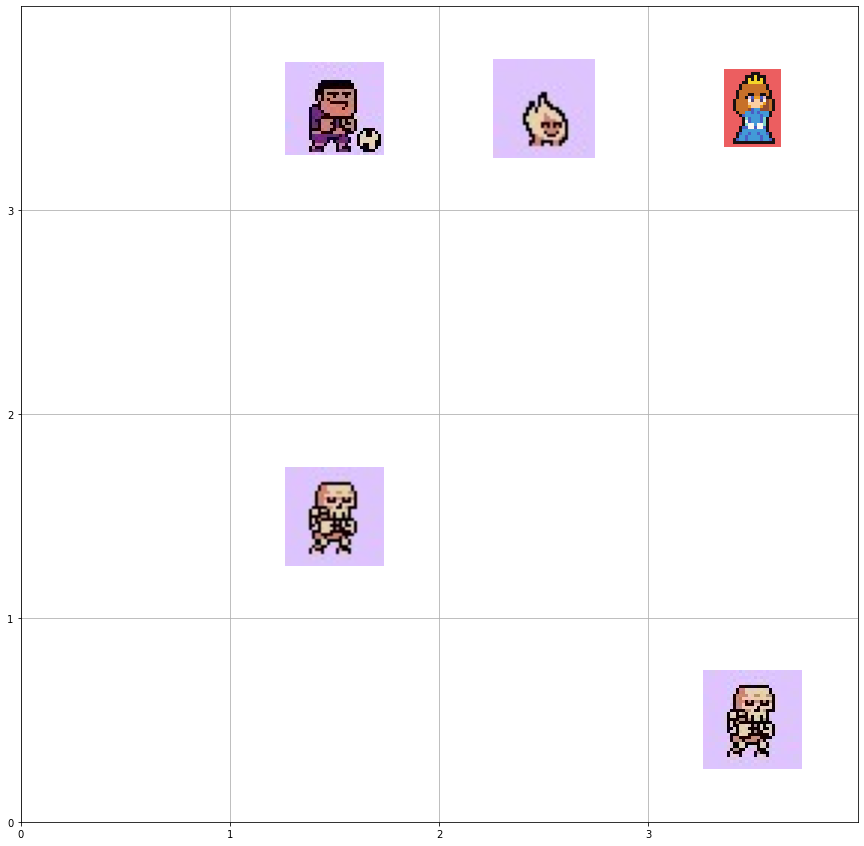

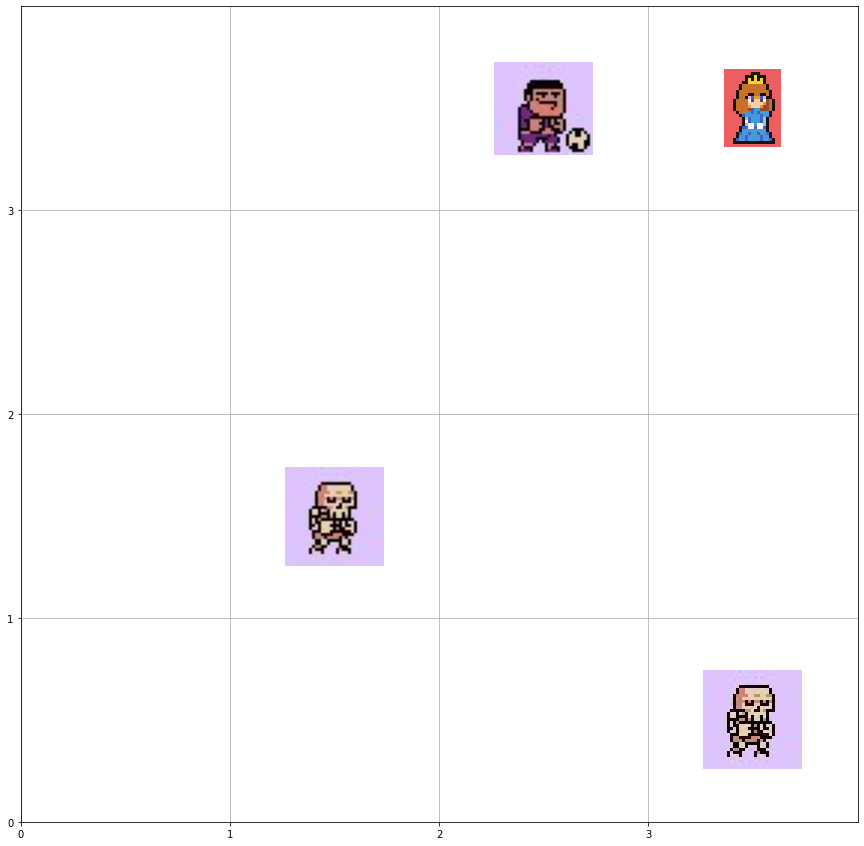

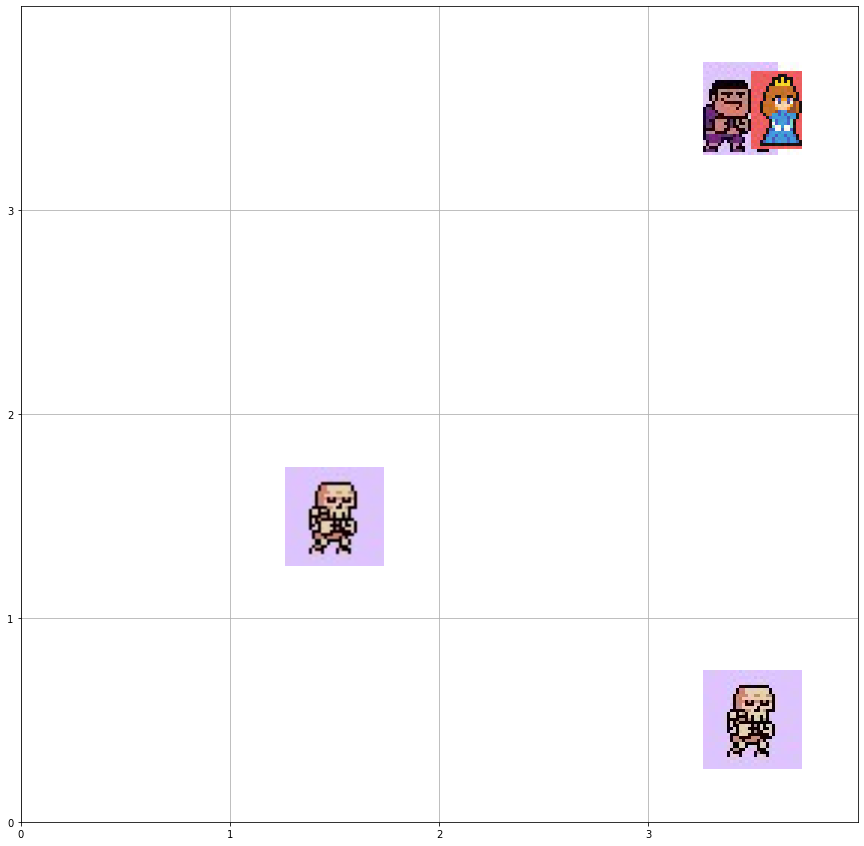

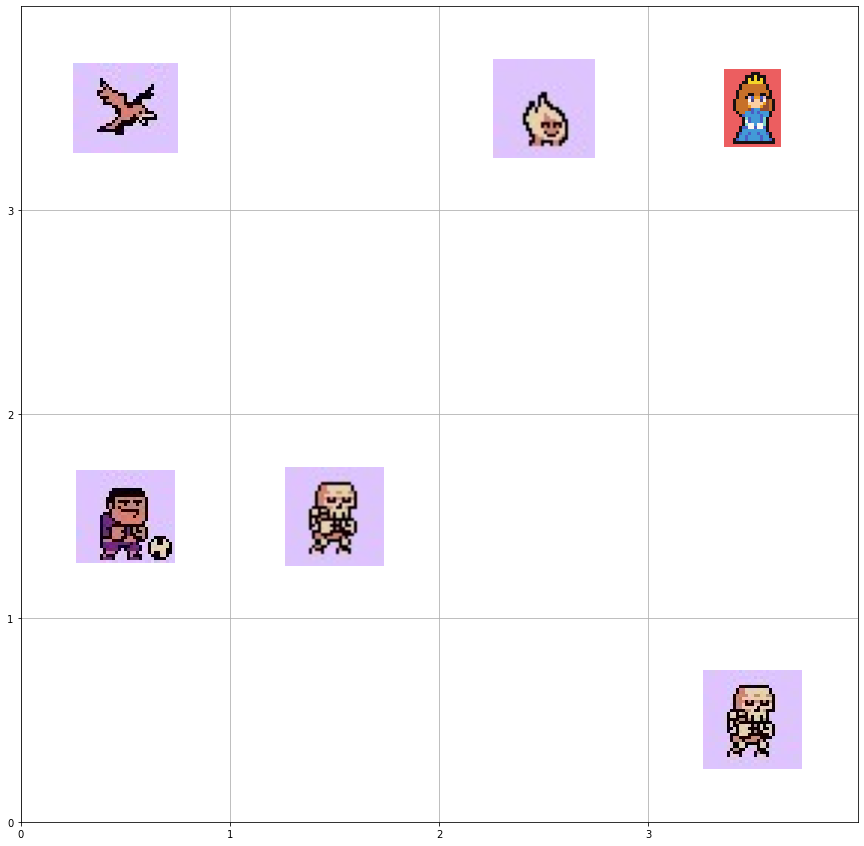

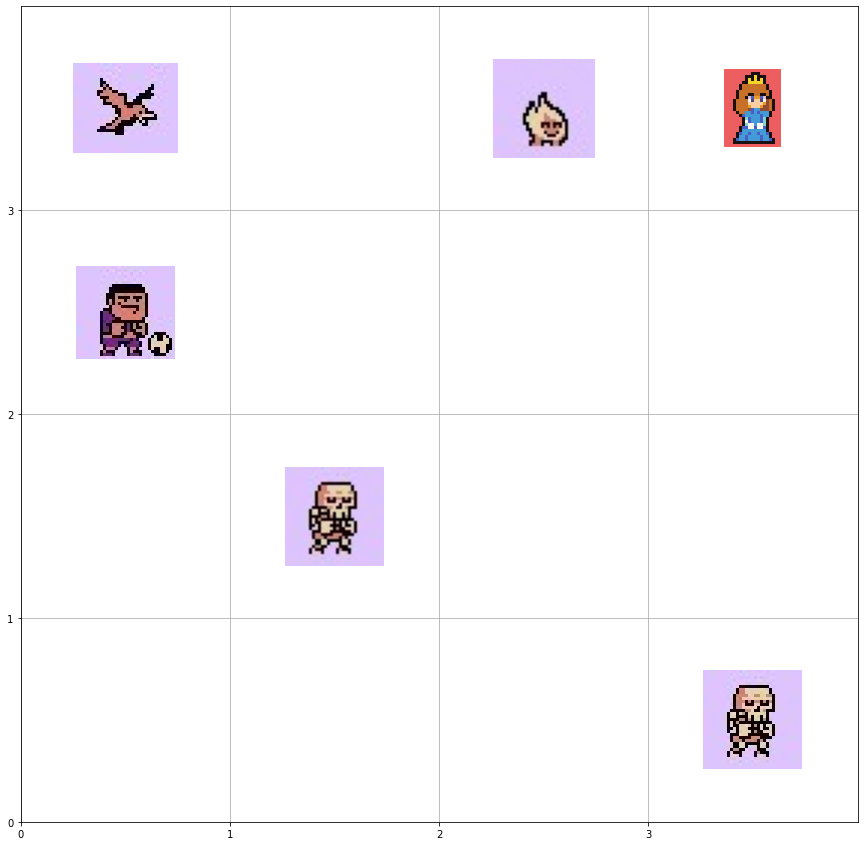

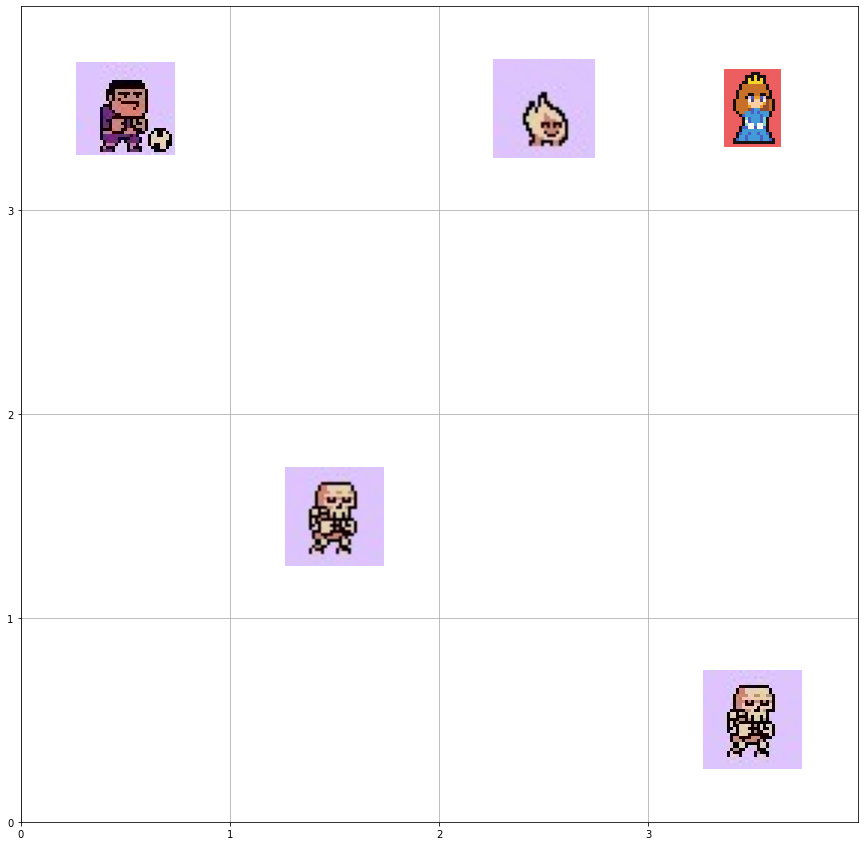

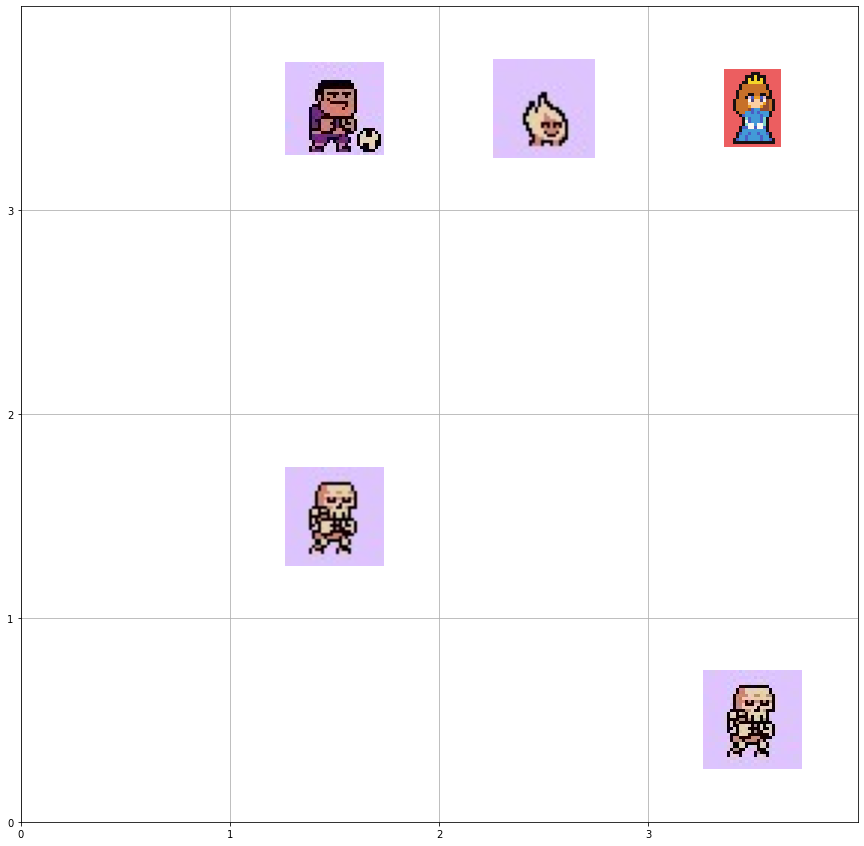

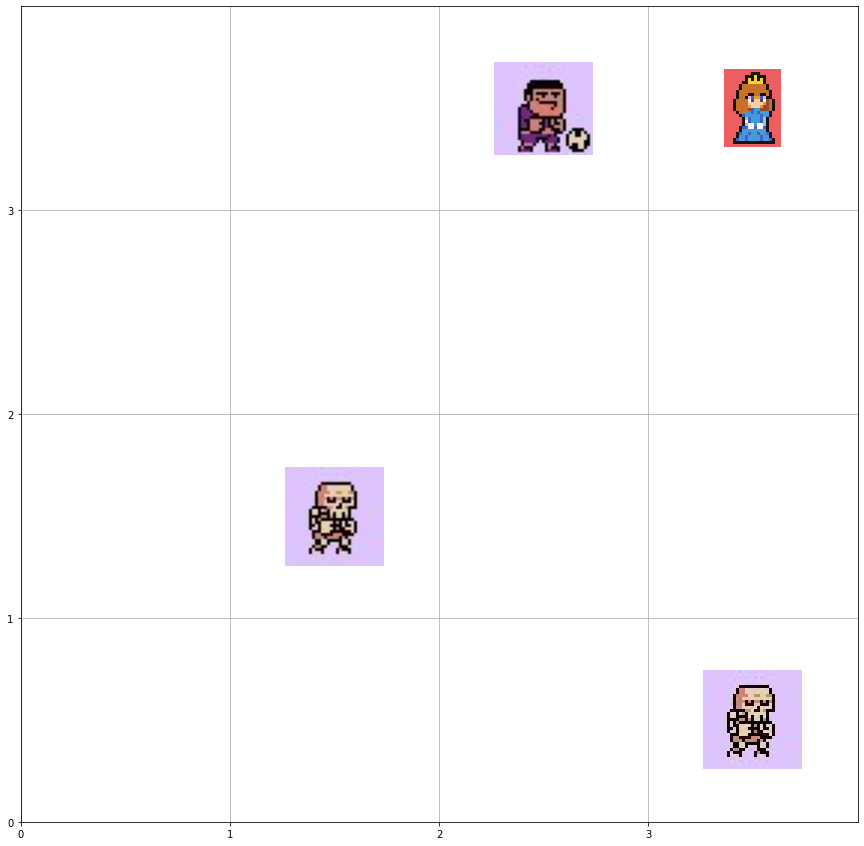

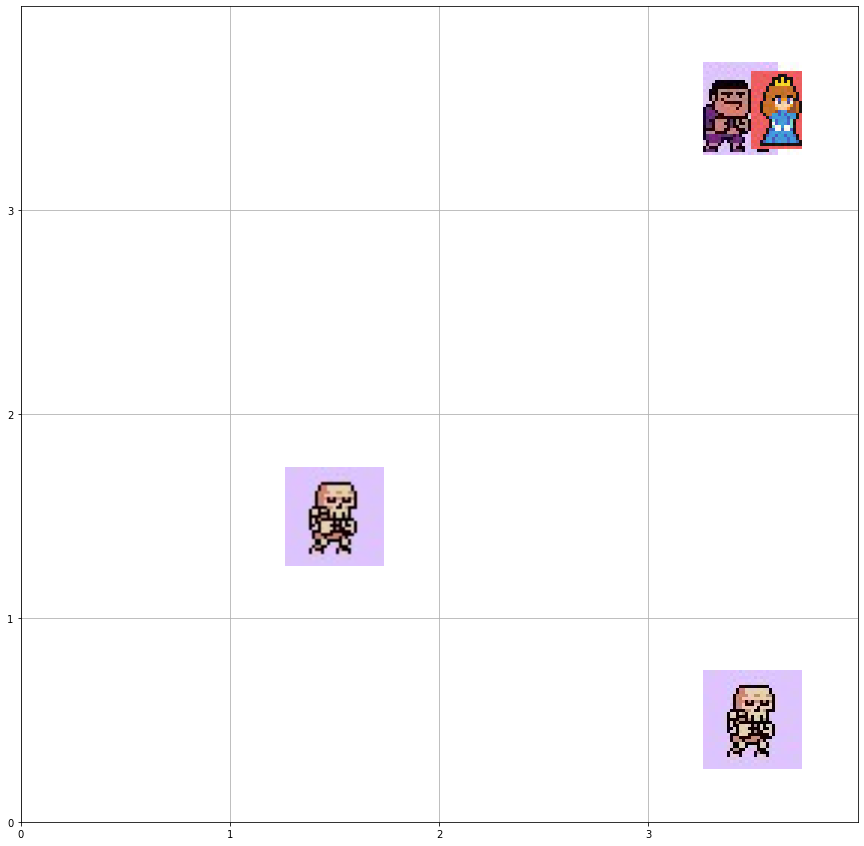

In [59]:
sd1 = evaluate_model(env, agent, model1, 5)

**Reward per Episode**

Text(0.5, 0, 'Episodes')

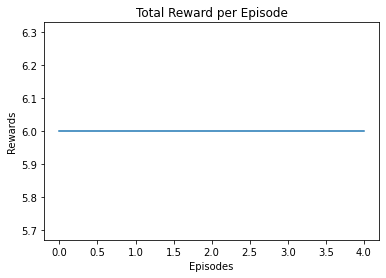

In [60]:
x = range(len(sd1))
plt.plot(x,sd1)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')